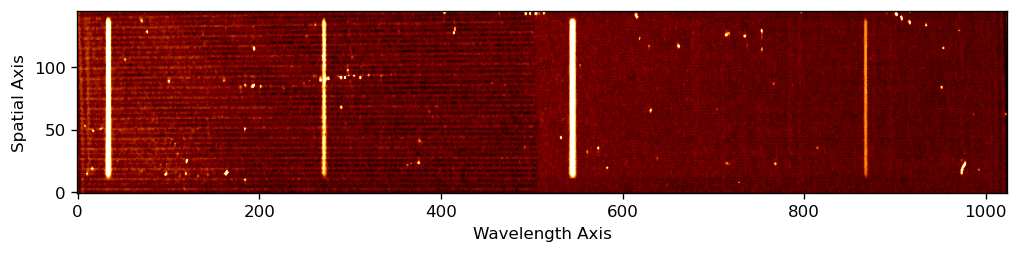

In [268]:
# import packages
from matplotlib import rcParams
rcParams['figure.dpi'] = 120
rcParams["savefig.dpi"] = 200
rcParams['figure.facecolor'] = 'w'

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from lmfit import Model
from lmfit.models import PolynomialModel, QuadraticModel, LinearModel, ConstantModel
from lmfit import minimize, Parameters, fit_report

import os
import warnings
warnings.filterwarnings('ignore')

# path joining version for other paths
notebook_path = os.path.abspath('/Users/RuoyanWang/Documents/LEICESTER/h3p/code/')
filepath = os.path.join(os.path.dirname(notebook_path), '02jun17/spec/')

# count number of fits files in folder
filesize = len([name for name in os.listdir(filepath) if os.path.isfile(os.path.join(filepath, name))])


# define normalization function
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# define guassian function, credit to pen and pants IDL's Gaussfit in Python
def gaussian_fit(x, a0, a1, a2, a3, a4, a5): 
    """
    x = data array
    a0 = height of guassian
    a1 = pixel position of Gaussian peak
    a2 = width of Gaussian
    a3 = constant term
    a4 = linear term
    a5 = quadratic term
    
    note: fwhm = a2 * np.sqrt(2 * np.log(2)) * 2
    """
    z = (x - a1) / a2
    y = a0 * np.exp(-z**2 / a2) + a3 + a4 * x + a5 * x**2
    return y

# load waverange
waverange = fits.open(filepath + 'order35/waverange.fits', ignore_missing_end=True)[0].data

# load skylines
skylines60m = fits.open(filepath + 'order35/skylines60m_order35.fits', ignore_missing_end=True)[0].data
skylines60p = fits.open(filepath + 'order35/skylines60p_order35.fits', ignore_missing_end=True)[0].data
skylines60p_shifted = fits.open(filepath + 'order35/skylines60p_shifted_order35.fits', ignore_missing_end=True)[0].data
# skylines_corrected = fits.open(filepath + 'order35/skylines_corrected_order35.fits', ignore_missing_end=True)[0].data

plt.figure(figsize=(10,2))
plt.imshow(skylines60m, aspect='auto', cmap='afmhot')
# plt.imshow(skylines, aspect='auto', extent=[waverange[0],waverange[-1],0,138], cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 1024
    # variables        = 2
    chi-square         = 4.8521e-12
    reduced chi-square = 4.7476e-15
    Akaike info crit   = -33770.6783
    Bayesian info crit = -33760.8153
[[Variables]]
    slope:      2.9990e-05 +/- 7.2842e-12 (0.00%) (init = 2.999e-05)
    intercept:  2.17920873 +/- 4.3033e-09 (0.00%) (init = 2.179209)
[[Correlations]] (unreported correlations are < 0.250)
    C(slope, intercept) = -0.866


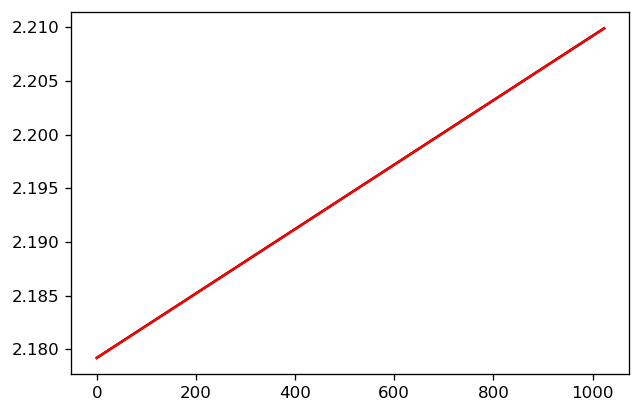

In [210]:
waveaxis = np.linspace(0, 1023, 1024)

mod = LinearModel()

pars = mod.guess(waverange, x=waveaxis)
out = mod.fit(waverange, pars, x=waveaxis)

print(out.fit_report(min_correl=0.25))

m = out.params['slope'].value
y0 = out.params['intercept'].value

wave_best_fit = m*waveaxis + y0

plt.figure()
plt.plot(waveaxis, waverange,'k', label = 'original')
plt.plot(waveaxis, wave_best_fit, 'r', label = 'best fit')

Text(0, 0.5, '$\\mathrm{ph/sec/arcsec^2/nm/m^2}$')

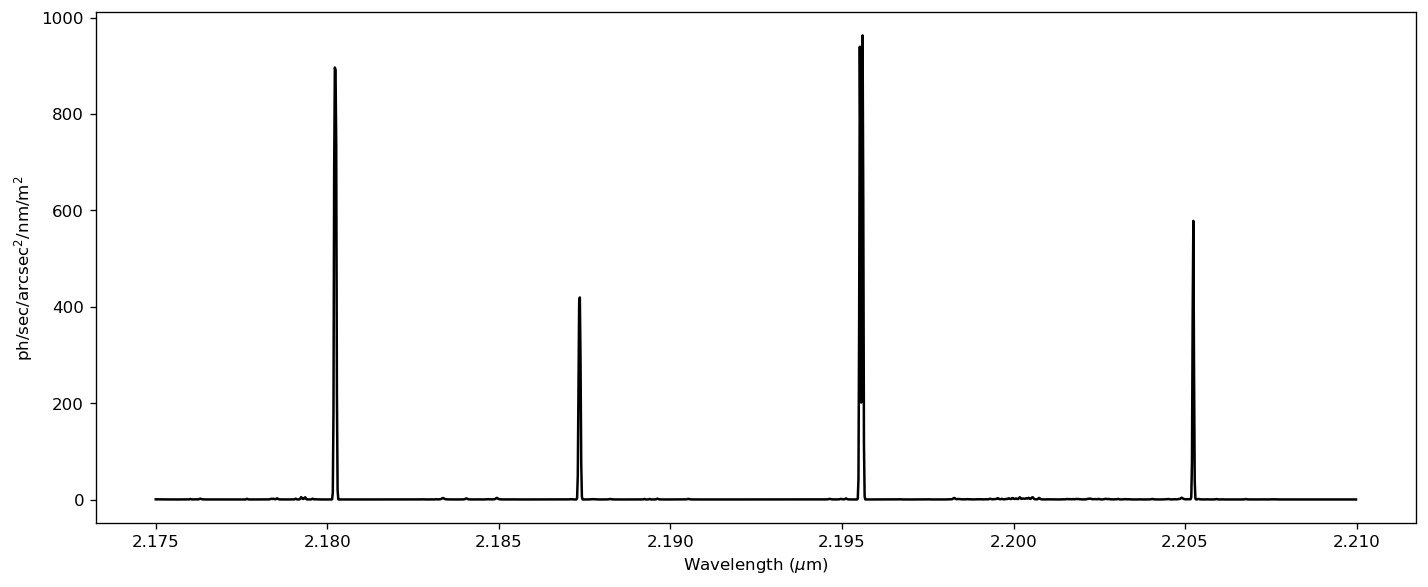

In [215]:
gemini_df = pd.read_csv('mk_skybg_zm_10_10_ph.dat', sep='\s+', header=None)
gemini_array = gemini_df.to_numpy()

wavelength = (gemini_array[63750:65500,0]/1000)
count = gemini_array[63750:65500,1]
#2.177-2.209

fig = plt.figure(figsize=(12,5), tight_layout=True)

fig.add_subplot(111)
plt.plot(wavelength, count, 'k', label='original')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('$\mathrm{ph/sec/arcsec^2/nm/m^2}$')

[[Model]]
    Model(gaussian_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1379
    # data points      = 20
    # variables        = 6
    chi-square         = 34912.5192
    reduced chi-square = 2493.75137
    Akaike info crit   = 161.297370
    Bayesian info crit = 167.271763
[[Variables]]
    a0:  1004.81569 +/- 38.8476102 (3.87%) (init = 900)
    a1:  2.18023109 +/- 1.3461e-06 (0.00%) (init = 2.1803)
    a2:  0.00123424 +/- 3.9888e-05 (3.23%) (init = 0.001)
    a3:  55946.7035 +/- 4.7133e+08 (842456.55%) (init = 0)
    a4: -16172.0329 +/- 4.3238e+08 (2673626.74%) (init = 0)
    a5: -4354.78963 +/- 99162806.0 (2277097.50%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -1.000
    C(a3, a4) = -1.000
    C(a3, a5) =  1.000
    C(a0, a2) = -0.344
    C(a1, a3) =  0.124
    C(a1, a4) = -0.124
    C(a1, a5) =  0.124
2.1802310920788788


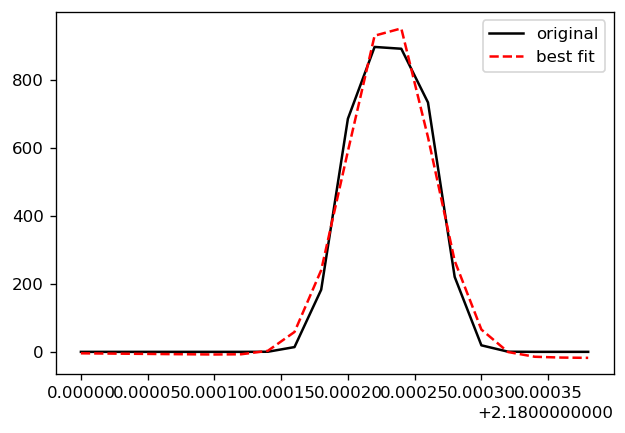

In [219]:
x1 = wavelength[250:270]
y1 = count[250:270]

# create lmfit model with defined gaussian
g1_model = Model(gaussian_fit)

# create parameters and add initial guess
g1_params = g1_model.make_params()
g1_params.add('a0', value=900, min=800)
g1_params.add('a1', value=2.1803, min=2.1801)
g1_params.add('a2', value=0.001)
g1_params.add('a3', value=0)
g1_params.add('a4', value=0)
g1_params.add('a5', value=0)

try:
    g1_result = g1_model.fit(y1, g1_params, x=x1)
except:
    pass

print(g1_result.fit_report())

plt.figure()
plt.plot(x1, y1, 'k', label='original')
plt.plot(x1, g1_result.best_fit, 'r--', label='best fit')
plt.legend()

print(g1_result.params['a1'].value)

[[Model]]
    Model(gaussian_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 92
    # data points      = 30
    # variables        = 6
    chi-square         = 2135.10141
    reduced chi-square = 88.9625586
    Akaike info crit   = 139.952161
    Bayesian info crit = 148.359346
[[Variables]]
    a0:  456.058564 +/- 7.63157901 (1.67%) (init = 405)
    a1:  2.18735202 +/- 5.1512e-07 (0.00%) (init = 2.18735)
    a2:  0.00113337 +/- 1.5212e-05 (1.34%) (init = 0.004)
    a3:  6244.56929 +/- 50362667.0 (806503.45%) (init = 0)
    a4: -1887.88821 +/- 46051006.8 (2439286.74%) (init = 0)
    a5: -442.377339 +/- 10527119.9 (2379669.79%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -1.000
    C(a3, a4) = -1.000
    C(a3, a5) =  1.000
    C(a0, a2) = -0.461
    C(a1, a5) = -0.103
    C(a1, a4) =  0.103
    C(a1, a3) = -0.103
2.1873520195513567


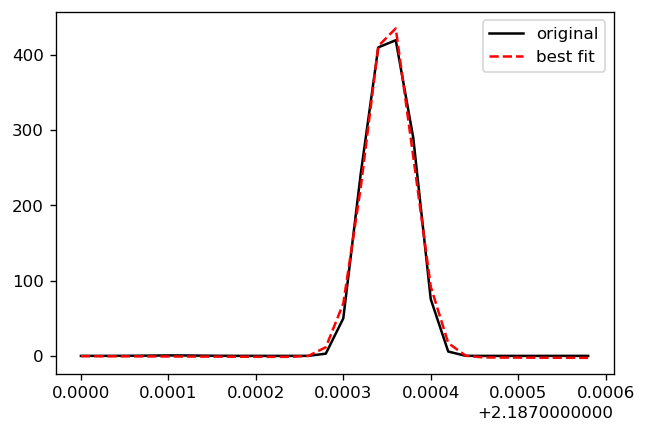

In [220]:
x2 = wavelength[600:630]
y2 = count[600:630]

# create lmfit model with defined gaussian
g2_model = Model(gaussian_fit)
#print('parameter names: {}'.format(g2model.param_names))
#print('independent variables: {}'.format(g2model.independent_vars))


# create parameters and add initial guess
g2_params = g2_model.make_params()
g2_params.add('a0', value=405)
g2_params.add('a1', value=2.18735)
g2_params.add('a2', value=0.004)
g2_params.add('a3', value=0)
g2_params.add('a4', value=0)
g2_params.add('a5', value=0)

try:
    g2_result = g2_model.fit(y2, g2_params, x=x2)
except:
    pass

print(g2_result.fit_report())

plt.figure()
plt.plot(x2, y2, 'k', label='original')
plt.plot(x2, g2_result.best_fit, 'r--', label='best fit')
plt.legend()

print(g2_result.params['a1'].value)

[[Model]]
    Model(gaussian_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 93
    # data points      = 20
    # variables        = 6
    chi-square         = 1.79996298
    reduced chi-square = 0.12856878
    Akaike info crit   = -36.1593235
    Bayesian info crit = -30.1849298
[[Variables]]
    a0:  585.376058 +/- 0.35022005 (0.06%) (init = 590)
    a1:  2.20523704 +/- 1.2575e-08 (0.00%) (init = 2.2052)
    a2:  8.7844e-04 +/- 4.1771e-07 (0.05%) (init = 0.002)
    a3:  5077.36574 +/- 2562362.86 (50466.38%) (init = 0)
    a4: -4350.72661 +/- 2323950.98 (53415.24%) (init = 0)
    a5:  928.968437 +/- 526930.510 (56722.11%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a4) = -1.000
    C(a4, a5) = -1.000
    C(a3, a5) =  1.000
    C(a0, a2) = -0.454
2.205237044270536


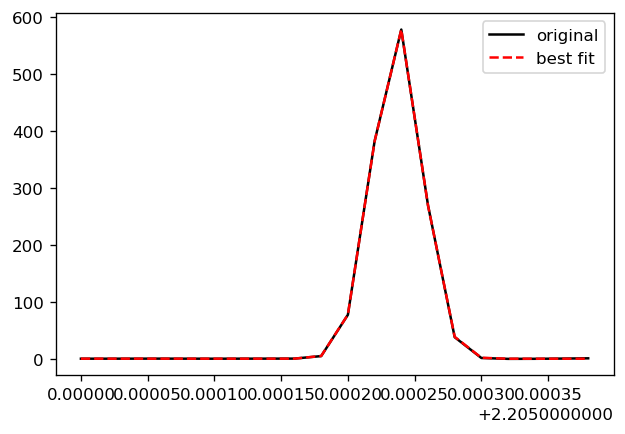

In [221]:
x3 = wavelength[1500:1520]
y3 = count[1500:1520]

# create lmfit model with defined gaussian
g3_model = Model(gaussian_fit)

# create parameters and add initial guess
g3_params = g3_model.make_params()
g3_params.add('a0', value=590, min=530)
g3_params.add('a1', value=2.2052)
g3_params.add('a2', value=0.002)
g3_params.add('a3', value=0)
g3_params.add('a4', value=0)
g3_params.add('a5', value=0)

try:
    g3_result = g3_model.fit(y3, g3_params, x=x3)
except:
    pass

print(g3_result.fit_report())

plt.figure()
plt.plot(x3, y3, 'k', label='original')
plt.plot(x3, g3_result.best_fit, 'r--', label='best fit')
plt.legend()

print(g3_result.params['a1'].value)

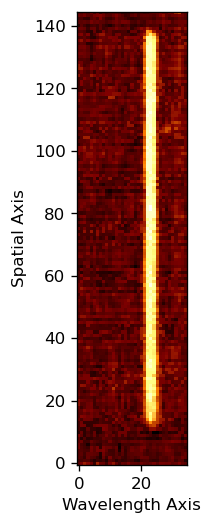

In [222]:
a = np.delete(skylines60m, np.s_[880:], 1)
b = np.delete(a, np.s_[:845], 1)

plt.figure(figsize=(2,5))
# plt.imshow(c, aspect='auto', extent=[waverange[120], waverange[179], 364, 225], cmap='afmhot')
plt.imshow(b, cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()

In [224]:
a = np.delete(skylines60m, np.s_[880:], 1)
b = np.delete(a, np.s_[:845], 1)
b = normalize(b)
waveaxis = np.linspace(0, np.size(b,1)-1, np.size(b,1))
# waveaxis = waverange[810:860]*100000

upper_skyline = 135
lower_skyline = 15

sky4_a1 = np.zeros(upper_skyline - lower_skyline)

for i in range(lower_skyline, upper_skyline):           
    if i >= lower_skyline and i < upper_skyline:
        # create lmfit model with defined gaussian
        sky4_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky4_params = sky4_model.make_params()
        sky4_params.add('a0', value=0.8, min=0.2, max=1)
        sky4_params.add('a1', value=23, min=18, max=28)
        sky4_params.add('a2', value=3)
        sky4_params.add('a3', value=0.3)
        sky4_params.add('a4', value=0)
        sky4_params.add('a5', value=0)
    
        try:
            sky4_fit_result = sky4_model.fit(b[i], sky4_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky4_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, b[i])
            plt.plot(waveaxis, sky4_fit_result.best_fit, 'r-', label='best fit')
            
        sky4_a1[i-lower_skyline] = sky4_fit_result.params['a1'].value
sky4_a1 = sky4_a1+845#/100000

[[Model]]
    Model(parabolic)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 5
    # data points      = 120
    # variables        = 3
    chi-square         = 0.81613731
    reduced chi-square = 0.00697553
    Akaike info crit   = -592.879729
    Bayesian info crit = -584.517254
[[Variables]]
    a:  1.9072e-05 +/- 7.1047e-06 (37.25%) (init = 1.907244e-05)
    b: -0.00423459 +/- 0.00108124 (25.53%) (init = -0.00423459)
    c:  868.087505 +/- 0.03580927 (0.00%) (init = 868.0875)
[[Correlations]] (unreported correlations are < 0.250)
    C(a, b) = -0.979
    C(b, c) = -0.938
    C(a, c) =  0.863


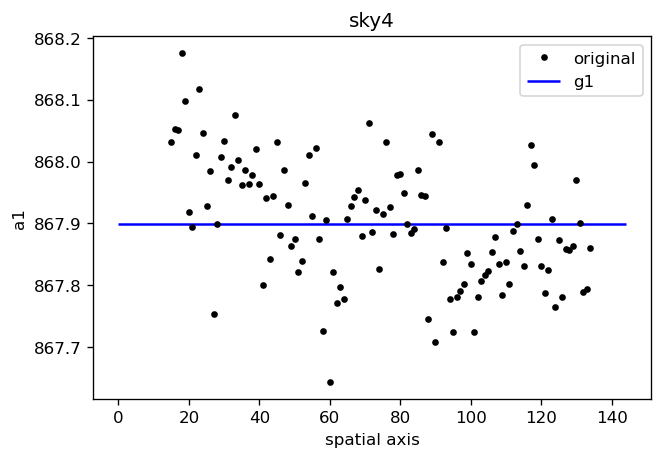

In [225]:
sky4_spat = np.linspace(0, len(sky4_a1)-1, len(sky4_a1))+15

x = sky4_spat
y = sky4_a1

mod = QuadraticModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

sky4_a = out.params['a'].value
sky4_b = out.params['b'].value
sky4_c = out.params['c'].value

sky4_spat_all = np.linspace(0, np.size(skylines60m,0)-1, np.size(skylines60m,0))
sky4_a1_best_fit = sky4_a*sky4_spat_all**2+sky4_b*sky4_spat_all+sky4_c

plt.figure()
plt.plot(sky4_spat, sky4_a1,'k.', label = 'original')
# plt.plot(sky4_spat_all, sky4_a1_best_fit, 'r', label = 'best fit')
plt.hlines((2.2052370442688503-y0)/m, xmin=sky4_spat_all[0], xmax=sky4_spat_all[-1], color='b', label='g1')
plt.xlabel('spatial axis')
plt.ylabel('a1')
plt.title('sky4')
plt.ticklabel_format(useOffset=False)
plt.legend()

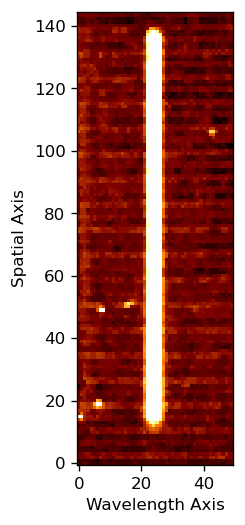

In [227]:
c = np.delete(skylines60m, np.s_[60:], 1)
d = np.delete(c, np.s_[:10], 1)

plt.figure(figsize=(2,5))
plt.imshow(d, cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()

In [228]:
c = np.delete(skylines60m, np.s_[60:], 1)
d = np.delete(c, np.s_[:10], 1)
d = normalize(d)
waveaxis = np.linspace(0, np.size(d,1)-1, np.size(d,1))
# waveaxis = waverange[810:860]*100000

upper_skyline = 135
lower_skyline = 15

sky1_a1 = np.zeros(upper_skyline - lower_skyline)

for i in range(lower_skyline, upper_skyline):           
    if i >= lower_skyline and i < upper_skyline:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=0.8, min=0.2, max=1)
        sky1_params.add('a1', value=23, min=18, max=28)
        sky1_params.add('a2', value=3)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(d[i], sky1_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, d[i])
            plt.plot(waveaxis, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1[i-lower_skyline] = sky1_fit_result.params['a1'].value
sky1_a1 = sky1_a1+10

[[Model]]
    Model(parabolic)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 5
    # data points      = 120
    # variables        = 3
    chi-square         = 0.49861941
    reduced chi-square = 0.00426170
    Akaike info crit   = -652.008471
    Bayesian info crit = -643.645996
[[Variables]]
    a: -1.9368e-05 +/- 5.5533e-06 (28.67%) (init = -1.936819e-05)
    b:  0.00322545 +/- 8.4513e-04 (26.20%) (init = 0.003225451)
    c:  33.9728106 +/- 0.02798974 (0.08%) (init = 33.97281)
[[Correlations]] (unreported correlations are < 0.250)
    C(a, b) = -0.979
    C(b, c) = -0.938
    C(a, c) =  0.863


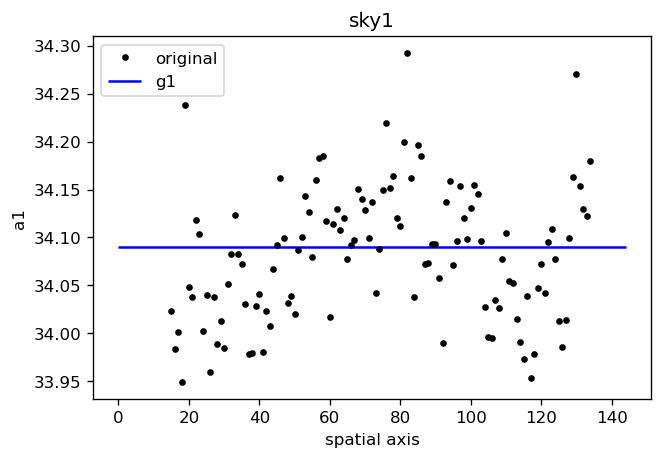

In [229]:
sky1_spat = np.linspace(0, len(sky1_a1)-1, len(sky1_a1))+15

x = sky1_spat
y = sky1_a1

mod = QuadraticModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

sky1_a = out.params['a'].value
sky1_b = out.params['b'].value
sky1_c = out.params['c'].value

sky1_spat_all = np.linspace(0, np.size(skylines60m,0)-1, np.size(skylines60m,0))
sky1_a1_best_fit = sky1_a*sky1_spat_all**2+sky1_b*sky1_spat_all+sky1_c
# sky1_a1_best_fit = sky1_c

plt.figure()
plt.plot(sky1_spat, sky1_a1,'k.', label = 'original')
# plt.plot(sky1_spat_all, sky1_a1_best_fit, 'r', label = 'best fit')
# plt.hlines(sky1_a1_best_fit, xmin=sky1_spat_all[0], xmax=sky1_spat_all[-1], color='r', label = 'best fit')
plt.hlines((2.1802310920788788-y0)/m, xmin=sky1_spat_all[0], xmax=sky1_spat_all[-1], color='b', label = 'g1')
plt.title('sky1')
plt.xlabel('spatial axis')
plt.ylabel('a1')
plt.ticklabel_format(useOffset=False)
plt.legend()

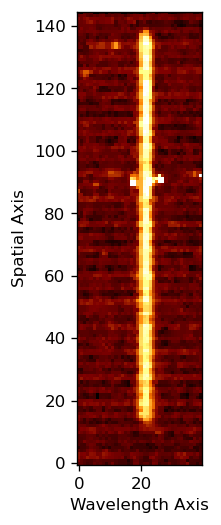

In [230]:
e = np.delete(skylines60m, np.s_[290:], 1)
f = np.delete(e, np.s_[:250], 1)

plt.figure(figsize=(2,5))
# plt.imshow(c, aspect='auto', extent=[waverange[120], waverange[179], 364, 225], cmap='afmhot')
plt.imshow(f, cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()

In [243]:
e = np.delete(skylines60m, np.s_[290:], 1)
f = np.delete(e, np.s_[:250], 1)
f = normalize(f)
waveaxis = np.linspace(0, np.size(f,1)-1, np.size(f,1))
# waveaxis = waverange[810:860]*100000

upper_skyline = 135
lower_skyline = 15

sky2_a1 = np.zeros(upper_skyline - lower_skyline)

for i in range(lower_skyline, upper_skyline):           
    if i >= lower_skyline and i < upper_skyline:
        # create lmfit model with defined gaussian
        sky2_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky2_params = sky2_model.make_params()
        sky2_params.add('a0', value=0.8, min=0.2, max=1)
        sky2_params.add('a1', value=20, min=15, max=25)
        sky2_params.add('a2', value=3)
        sky2_params.add('a3', value=0.3)
        sky2_params.add('a4', value=0)
        sky2_params.add('a5', value=0)
    
        try:
            sky2_fit_result = sky2_model.fit(f[i], sky2_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky2_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, f[i])
            plt.plot(waveaxis, sky2_fit_result.best_fit, 'r-', label='best fit')
            
        sky2_a1[i-lower_skyline] = sky2_fit_result.params['a1'].value
sky2_a1 = sky2_a1+250#/100000

[[Model]]
    Model(parabolic)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 5
    # data points      = 120
    # variables        = 3
    chi-square         = 4.30841567
    reduced chi-square = 0.03682407
    Akaike info crit   = -393.230580
    Bayesian info crit = -384.868105
[[Variables]]
    a: -1.3711e-05 +/- 1.6324e-05 (119.06%) (init = -1.371107e-05)
    b:  0.00265563 +/- 0.00248426 (93.55%) (init = 0.002655626)
    c:  271.453145 +/- 0.08227539 (0.03%) (init = 271.4531)
[[Correlations]] (unreported correlations are < 0.250)
    C(a, b) = -0.979
    C(b, c) = -0.938
    C(a, c) =  0.863


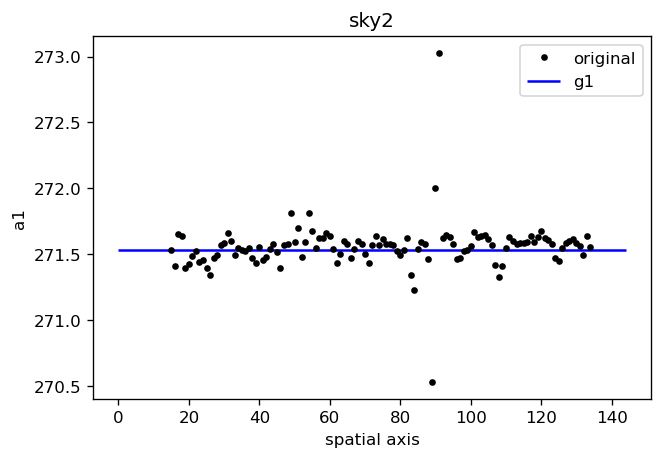

In [244]:
sky2_spat = np.linspace(0, len(sky2_a1)-1, len(sky2_a1))+15

x = sky2_spat
y = sky2_a1

mod = QuadraticModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

sky2_a = out.params['a'].value
sky2_b = out.params['b'].value
sky2_c = out.params['c'].value

sky2_spat_all = np.linspace(0, np.size(skylines60m,0)-1, np.size(skylines60m,0))
sky2_a1_best_fit = sky2_a*sky2_spat_all**2+sky2_b*sky2_spat_all+sky2_c
# sky2_a1_best_fit = sky2_c

plt.figure()
plt.plot(sky2_spat, sky2_a1,'k.', label = 'original')
# plt.plot(sky2_spat_all, sky2_a1_best_fit, 'r', label = 'best fit')
# plt.hlines(sky2_a1_best_fit, xmin=sky2_spat_all[0], xmax=sky2_spat_all[-1], color='r', label = 'best fit')
plt.hlines((2.1873520195513567-y0)/m, xmin=sky2_spat_all[0], xmax=sky2_spat_all[-1], color='b', label = 'g1')
plt.title('sky2')
plt.xlabel('spatial axis')
plt.ylabel('a1')
plt.ticklabel_format(useOffset=False)
plt.legend()

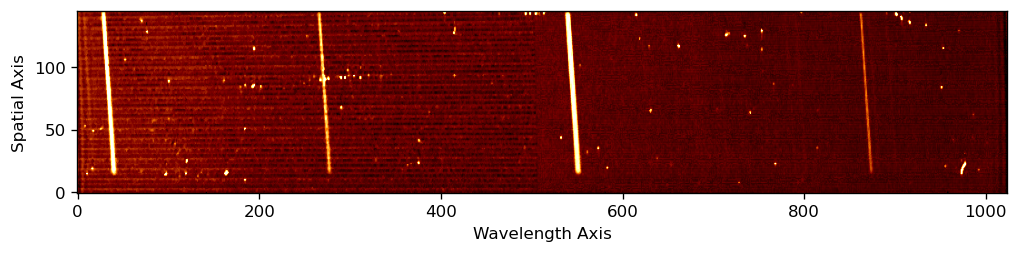

In [245]:
plt.figure(figsize=(10,2))
plt.imshow(skylines60p, aspect='auto', cmap='afmhot')
# plt.imshow(skylines, aspect='auto', extent=[waverange[0],waverange[-1],0,138], cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()

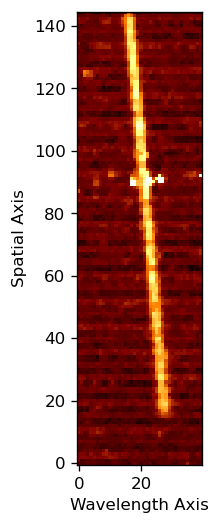

In [246]:
g = np.delete(skylines60p, np.s_[290:], 1)
h = np.delete(g, np.s_[:250], 1)

plt.figure(figsize=(2,5))
plt.imshow(h, cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()

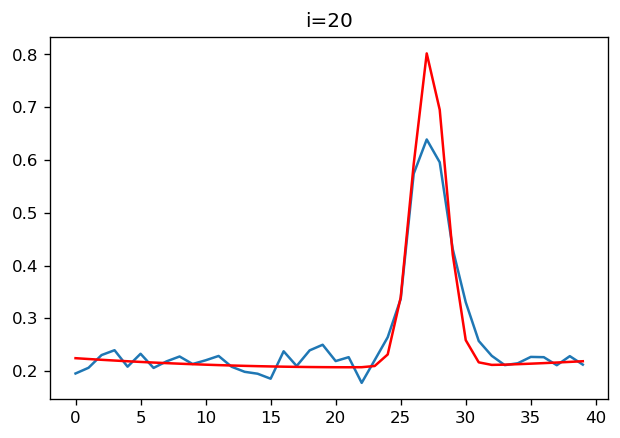

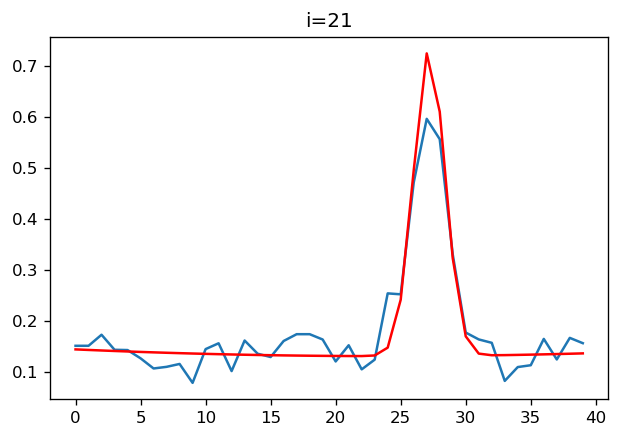

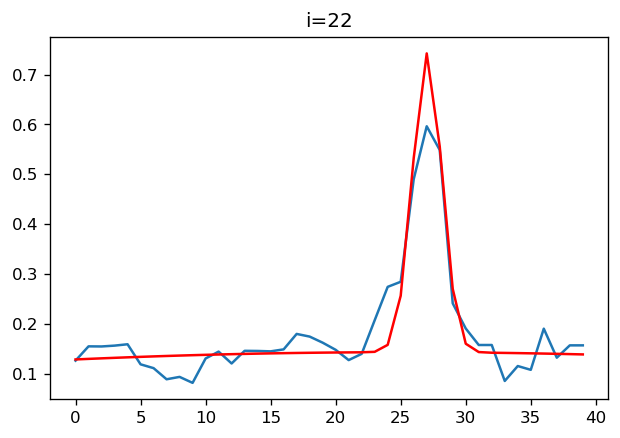

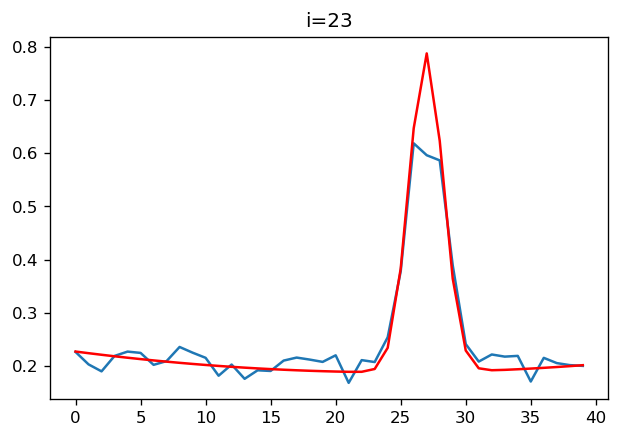

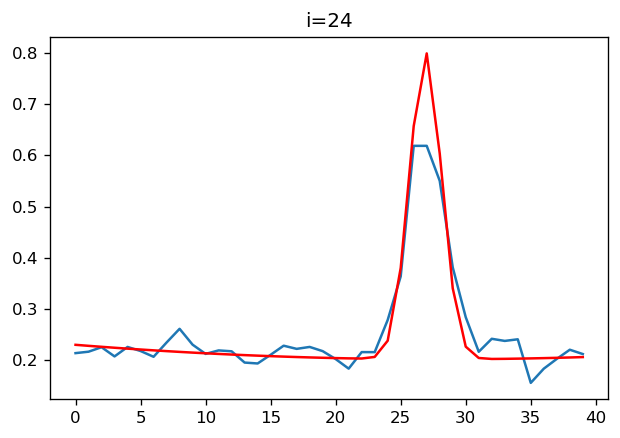

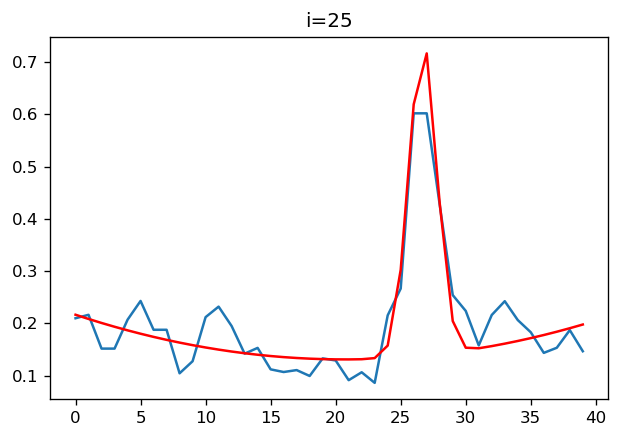

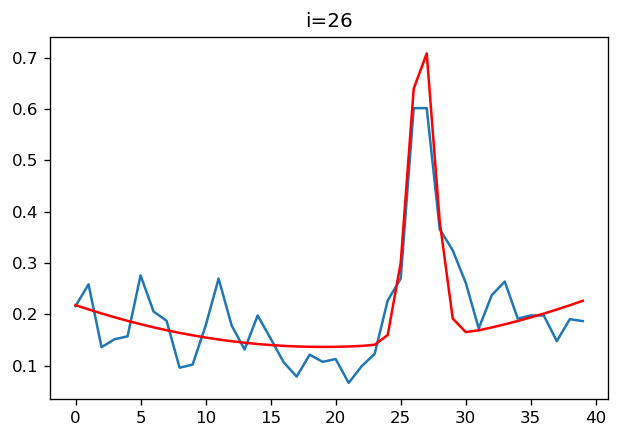

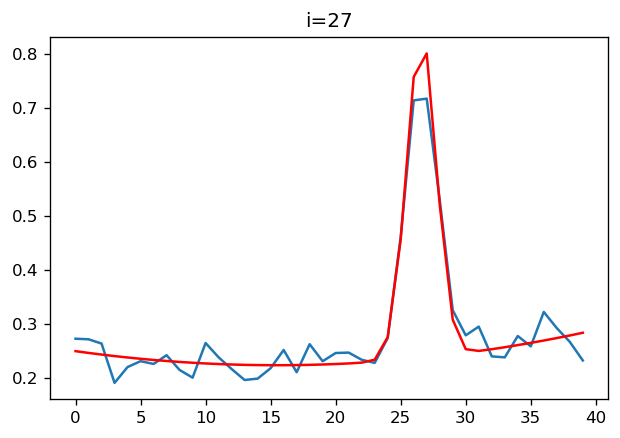

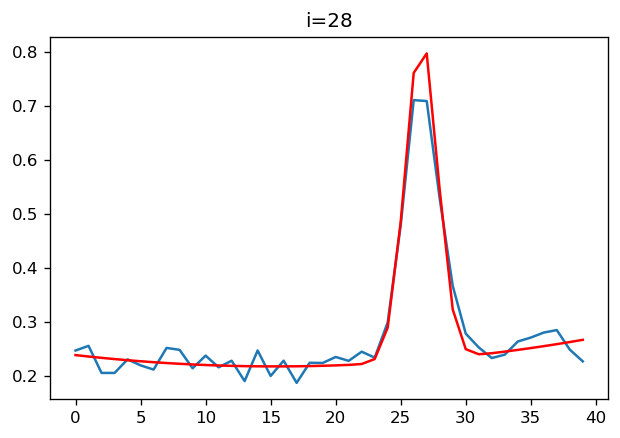

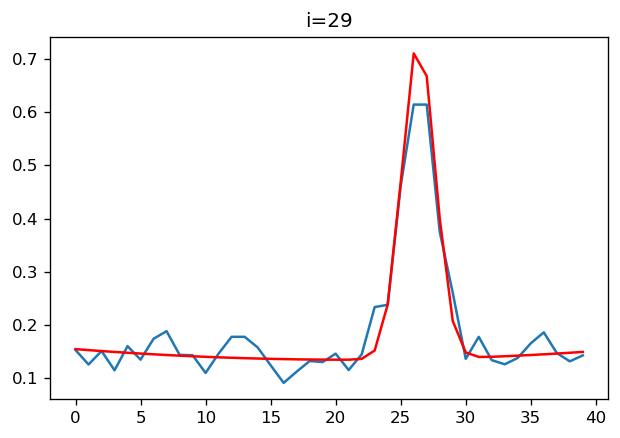

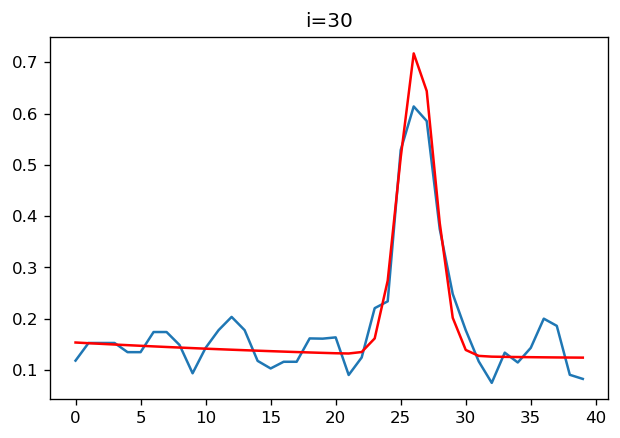

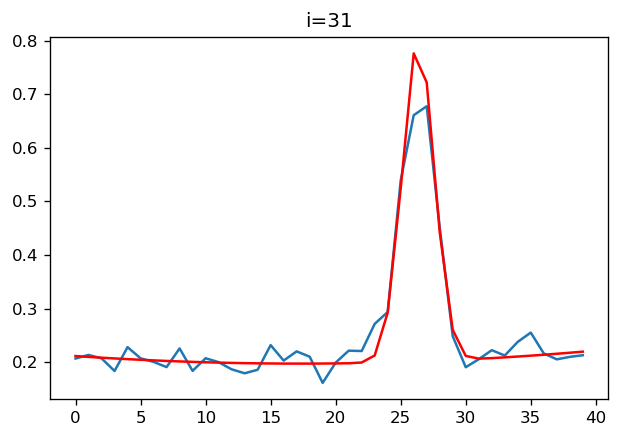

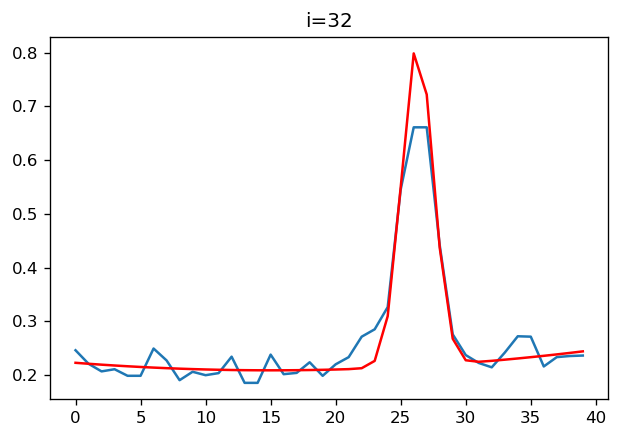

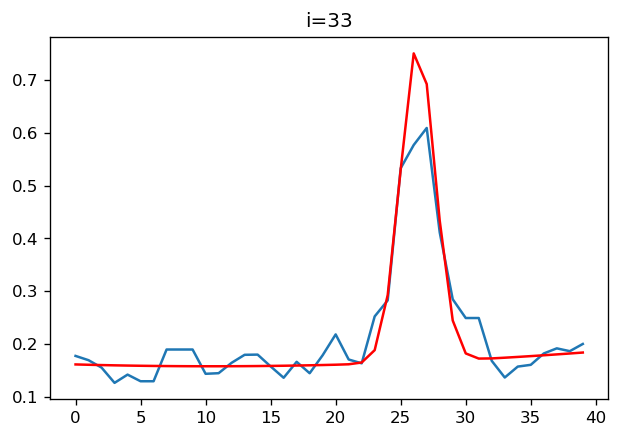

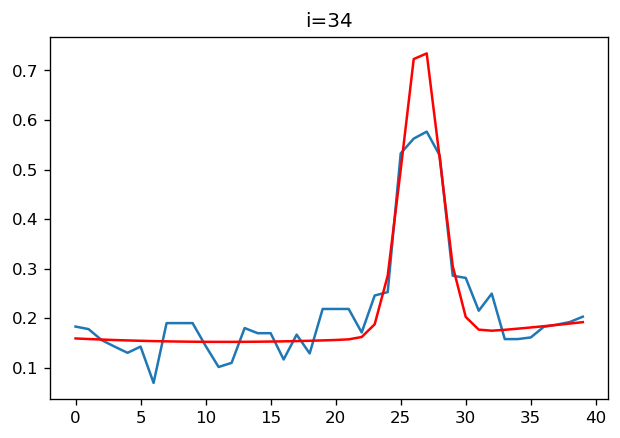

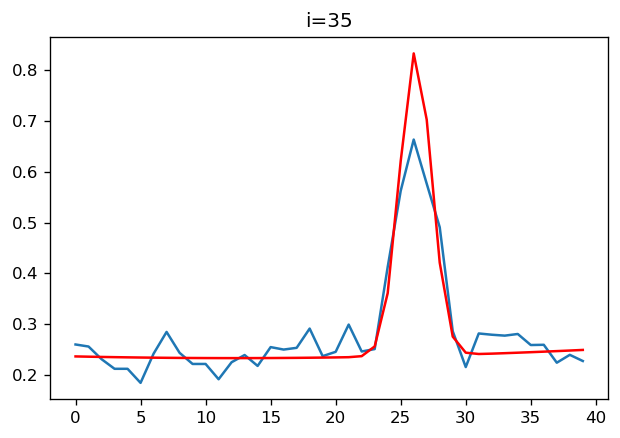

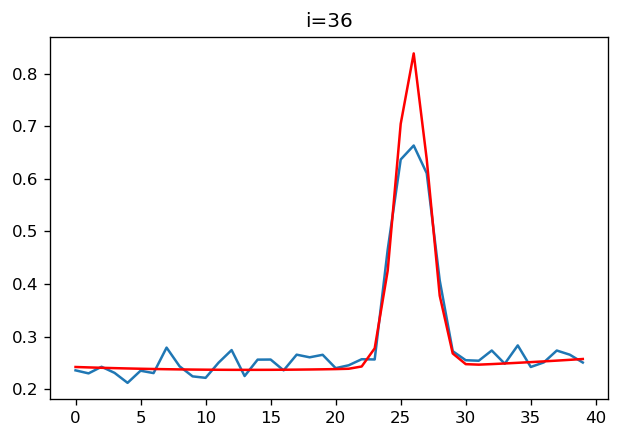

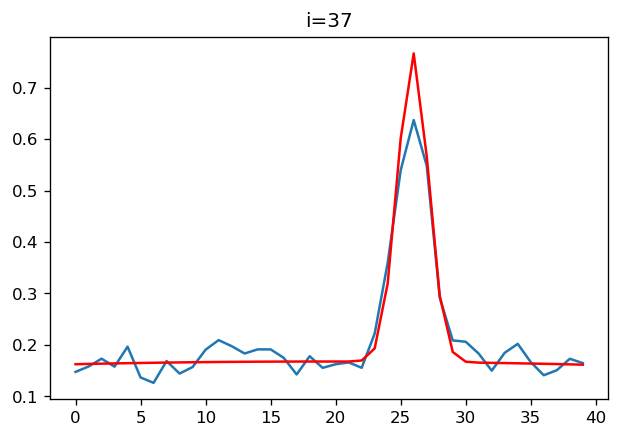

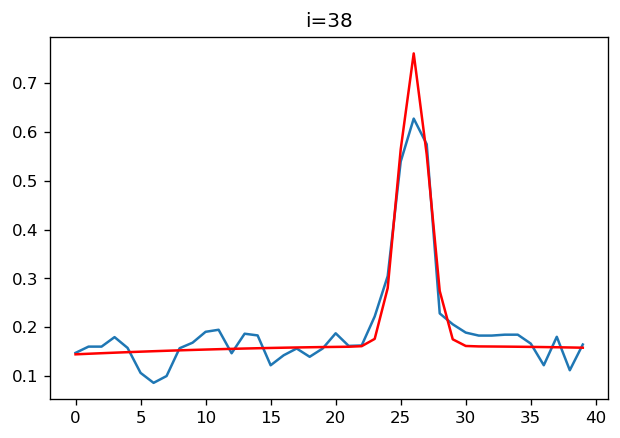

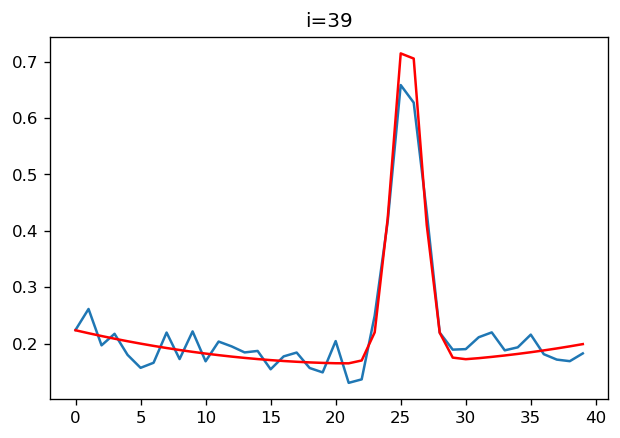

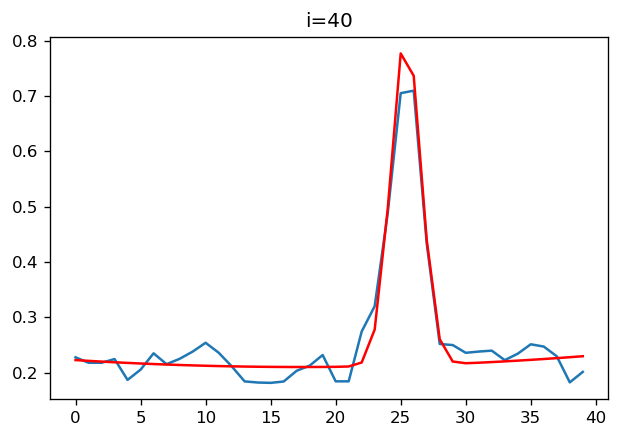

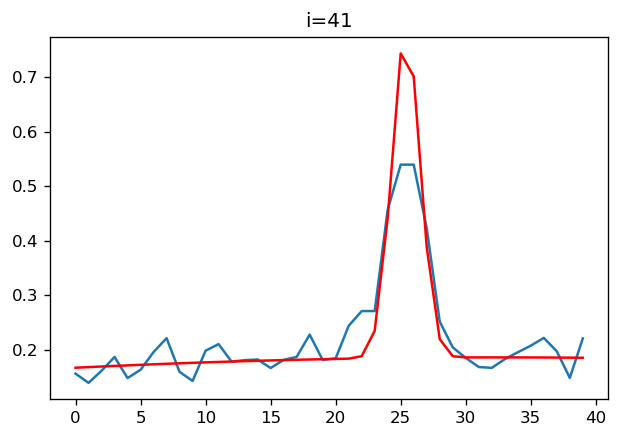

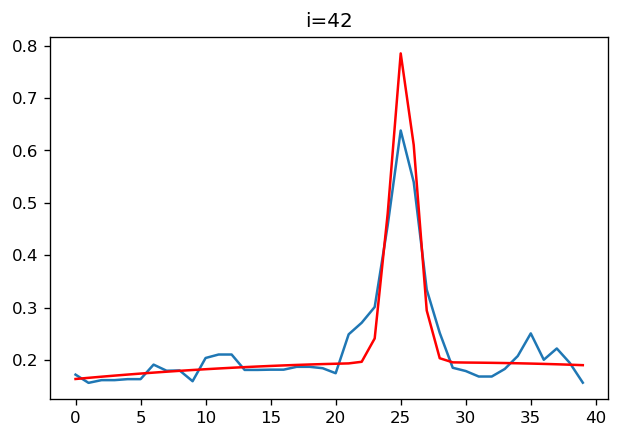

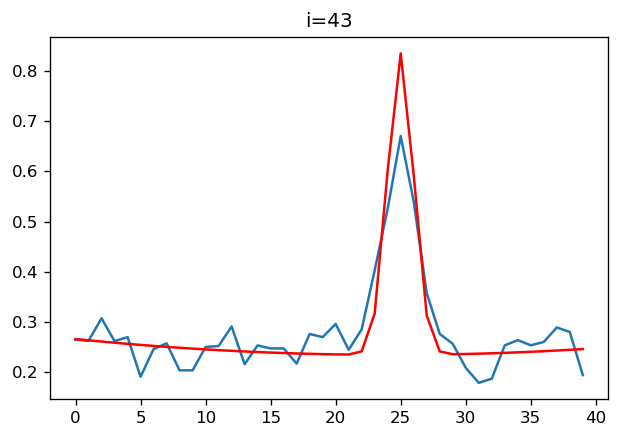

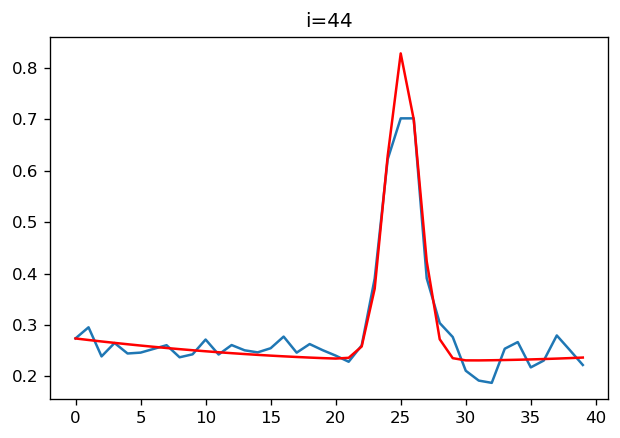

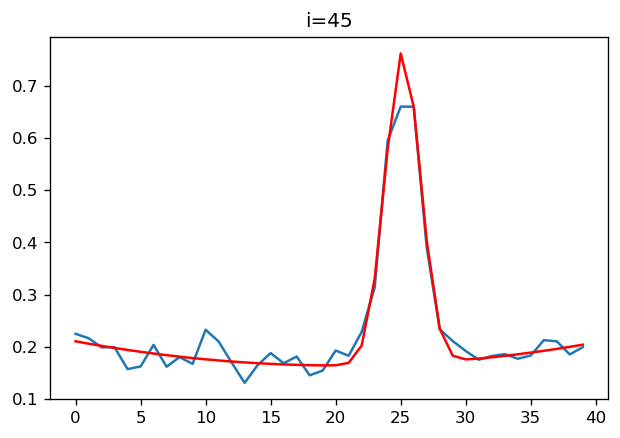

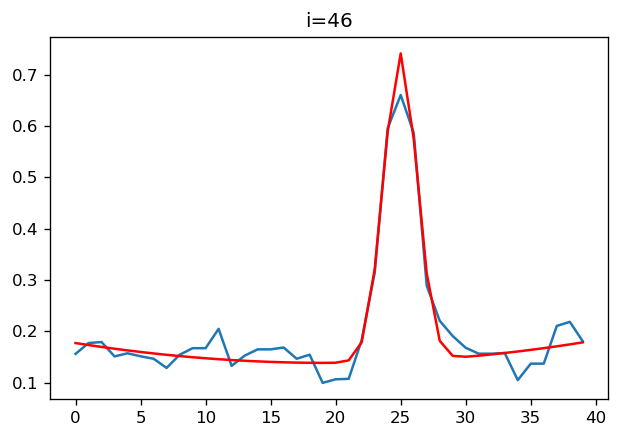

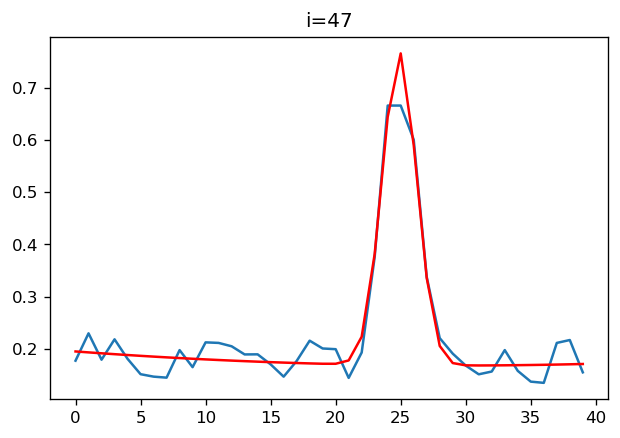

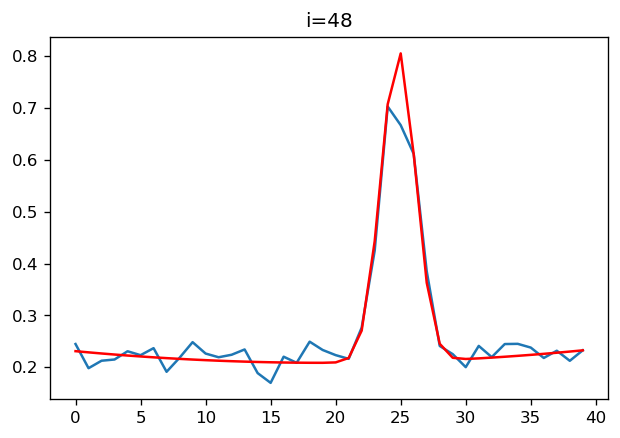

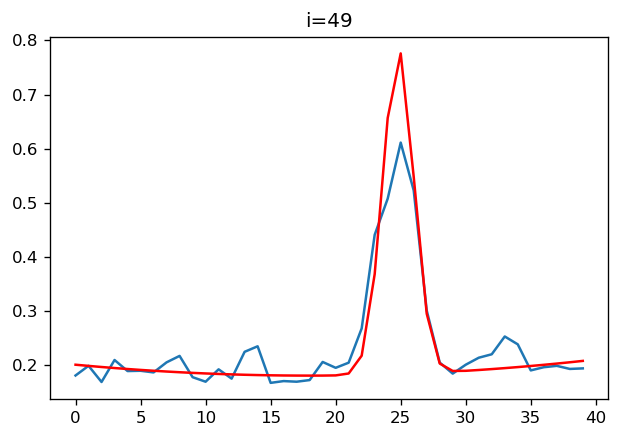

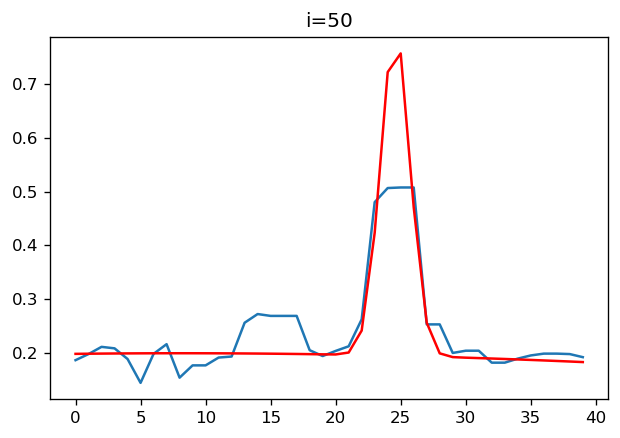

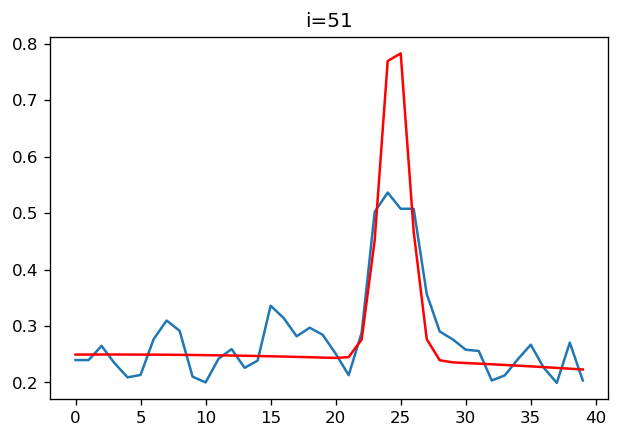

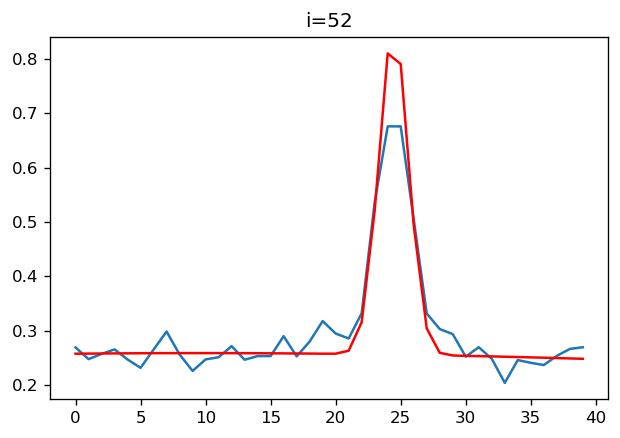

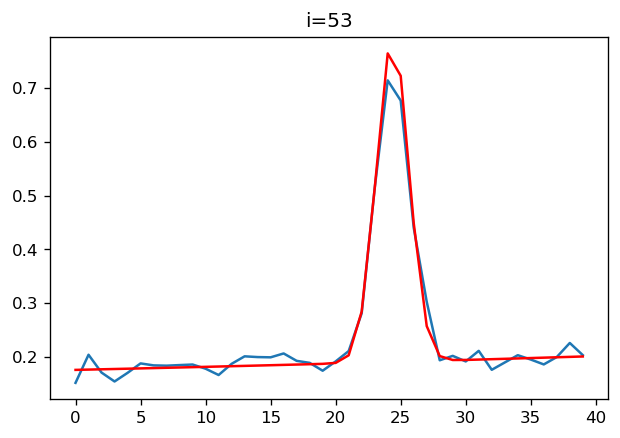

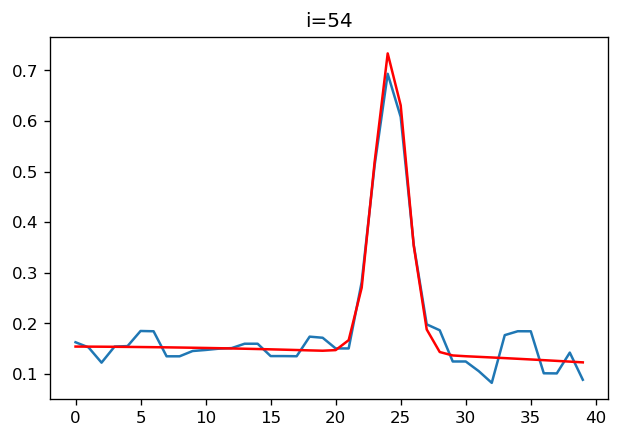

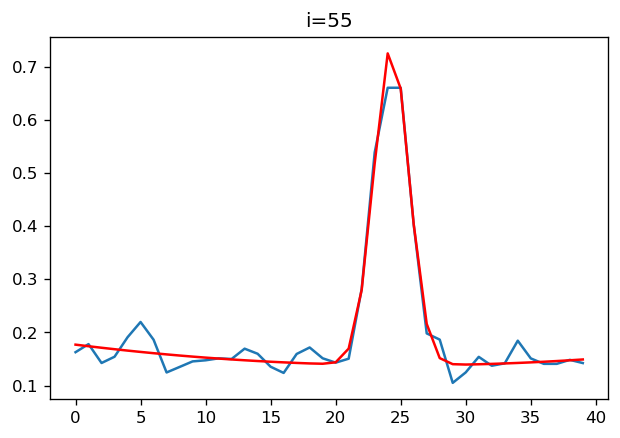

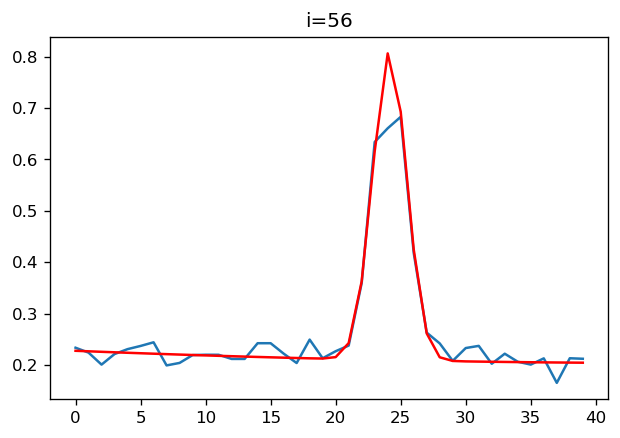

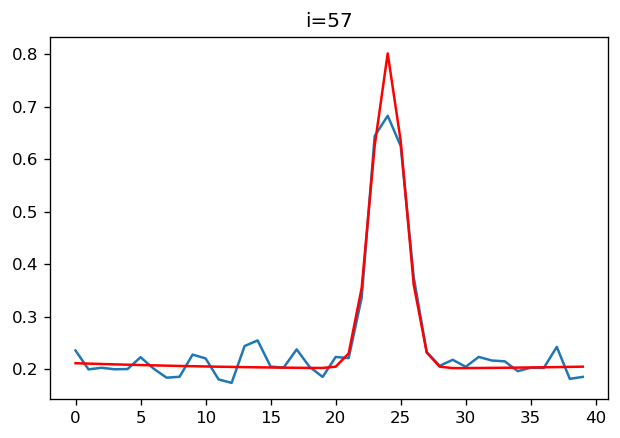

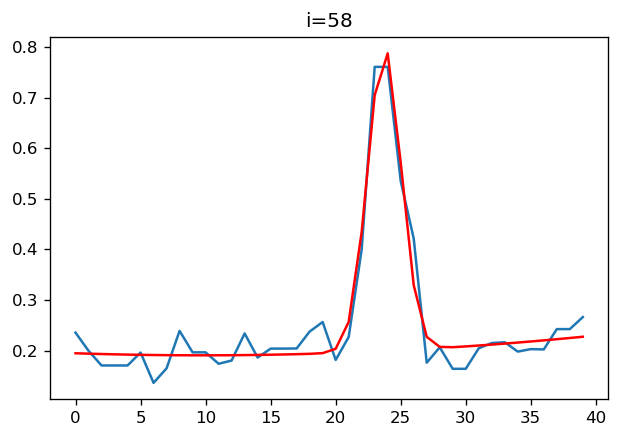

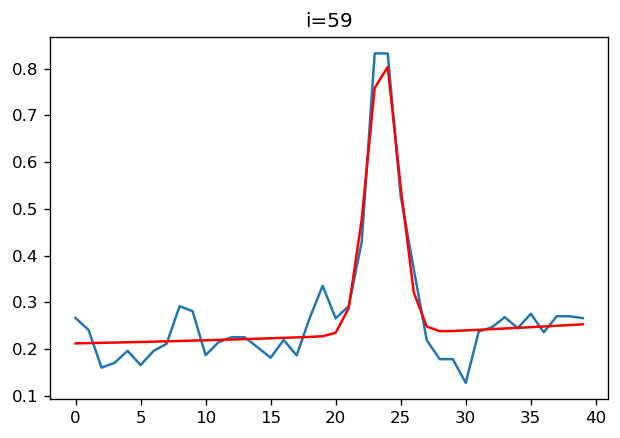

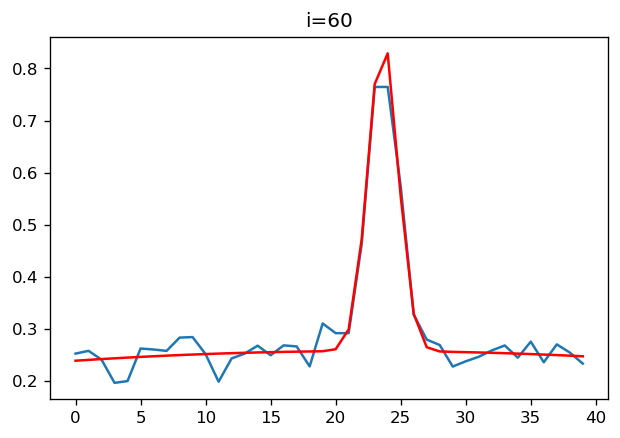

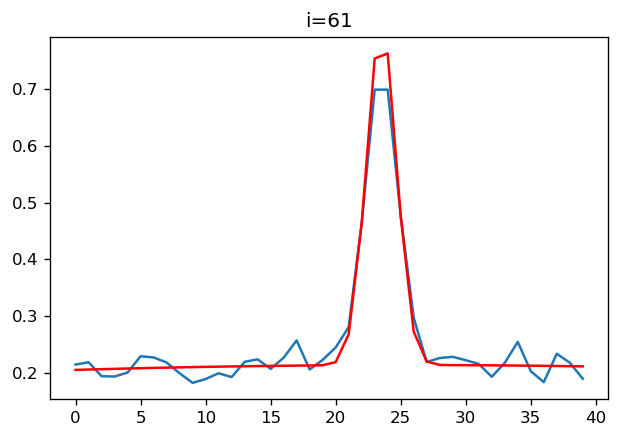

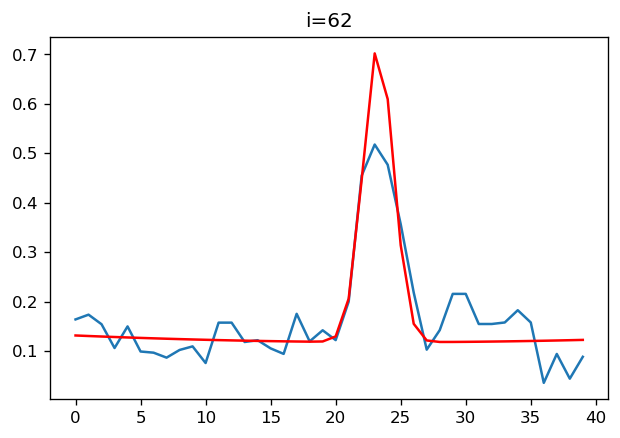

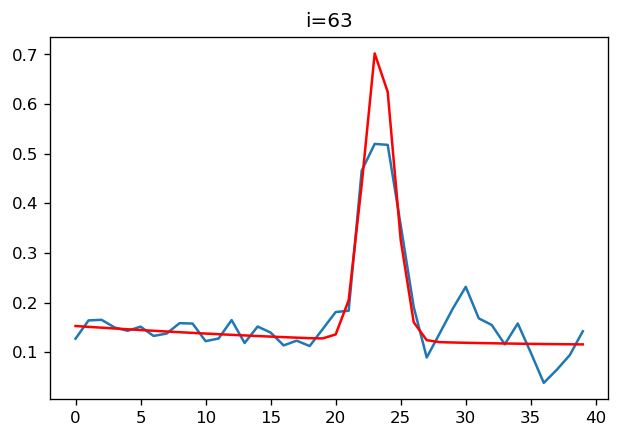

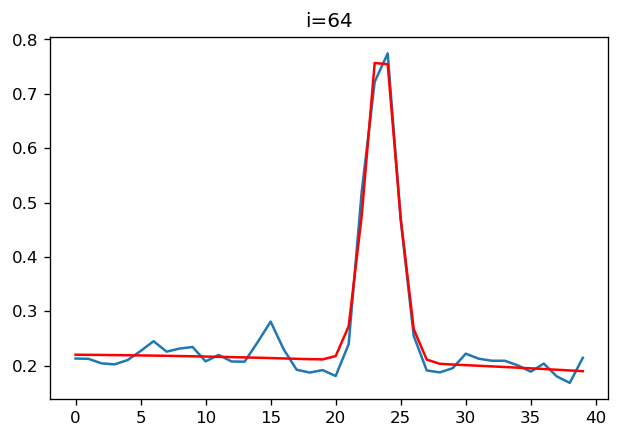

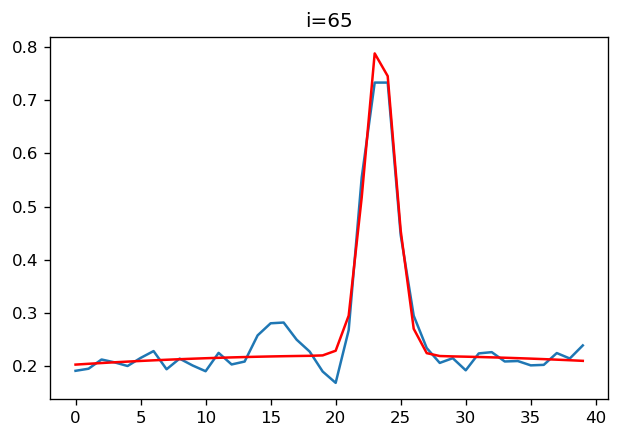

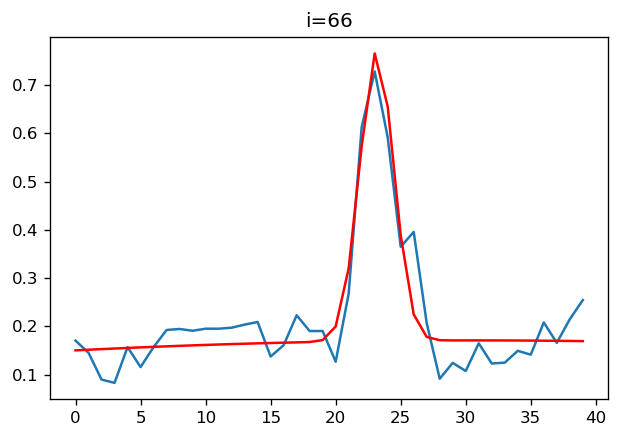

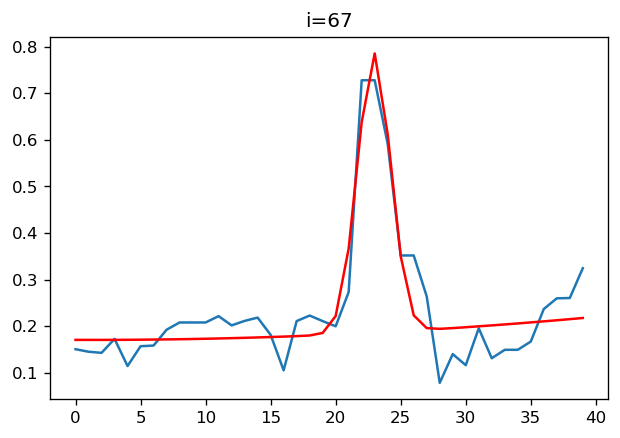

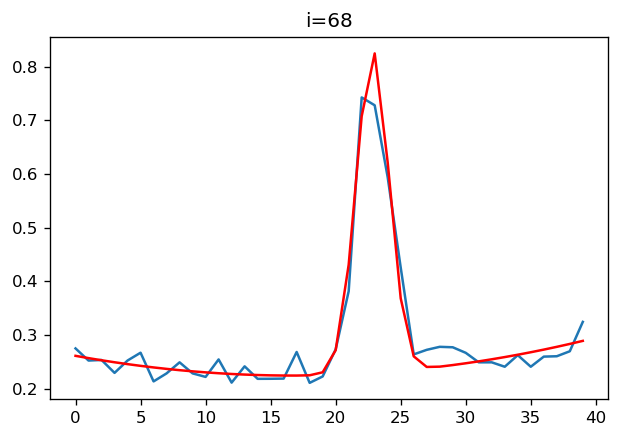

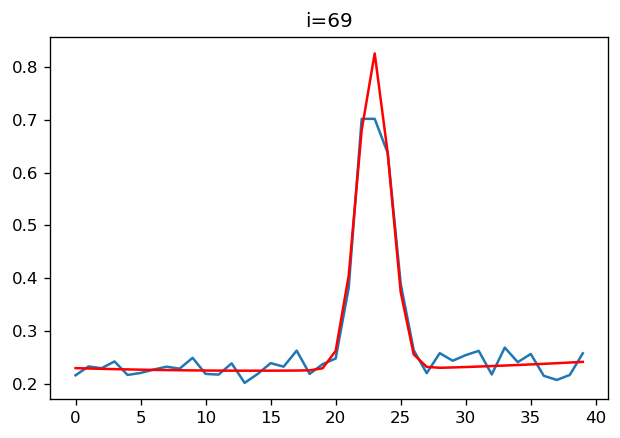

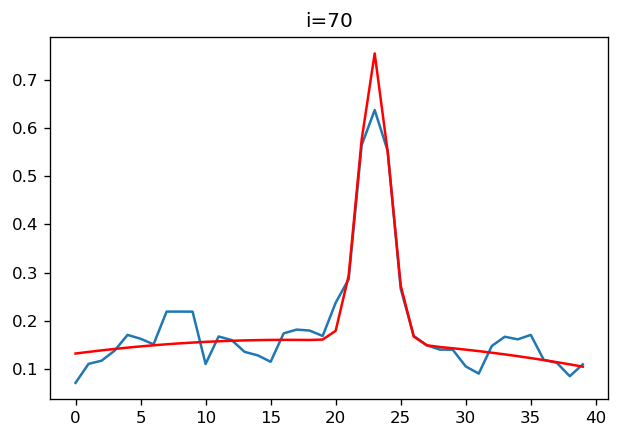

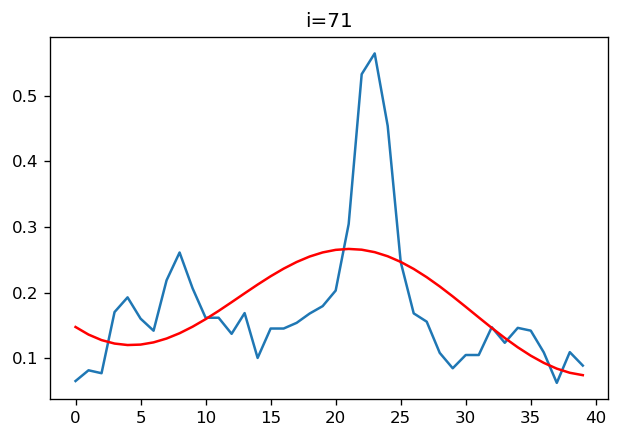

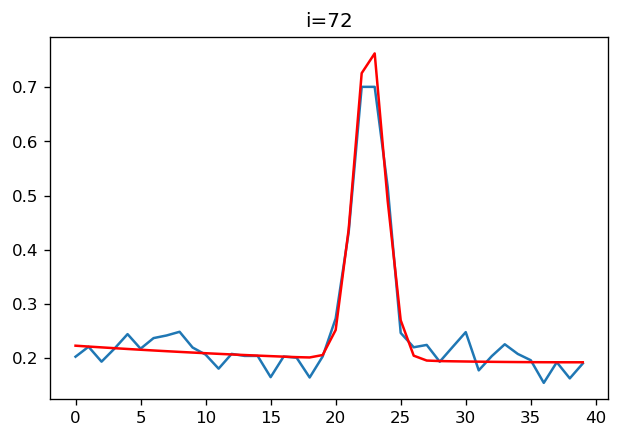

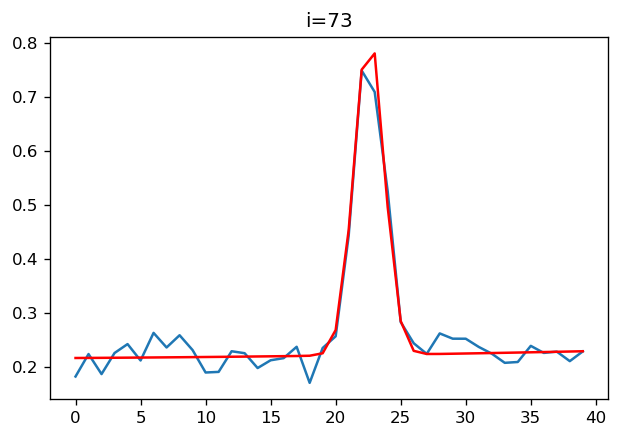

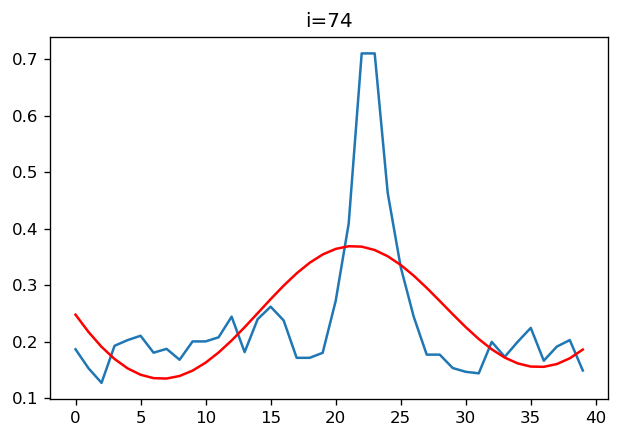

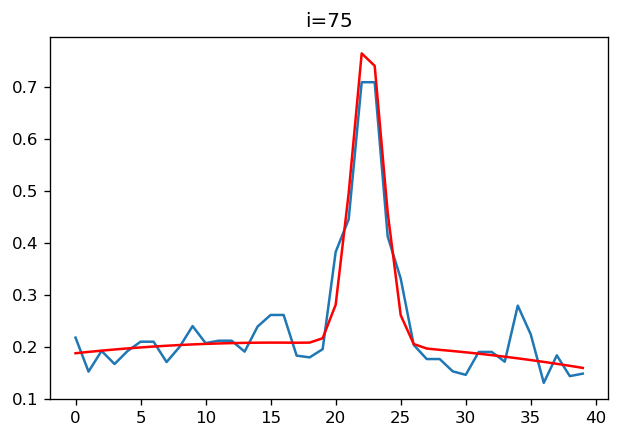

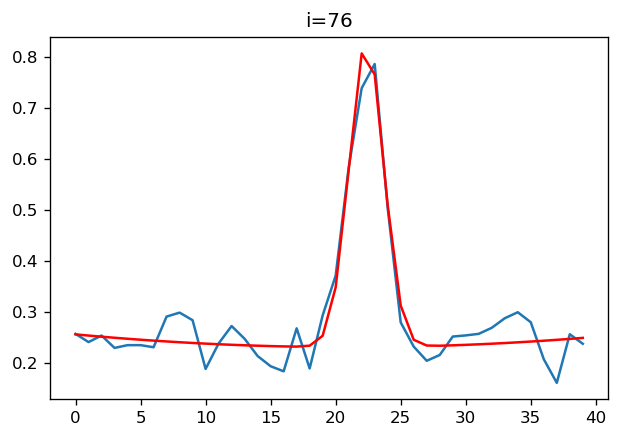

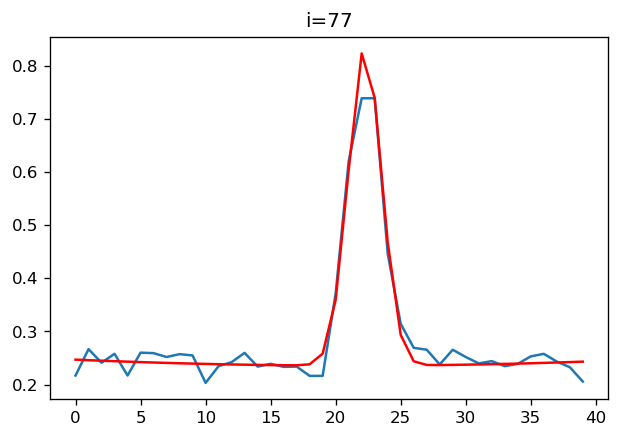

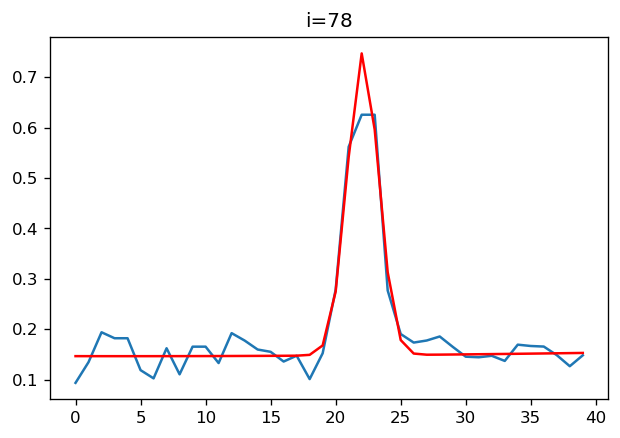

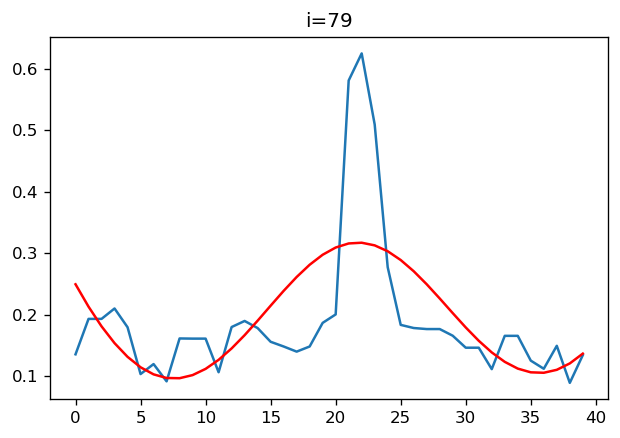

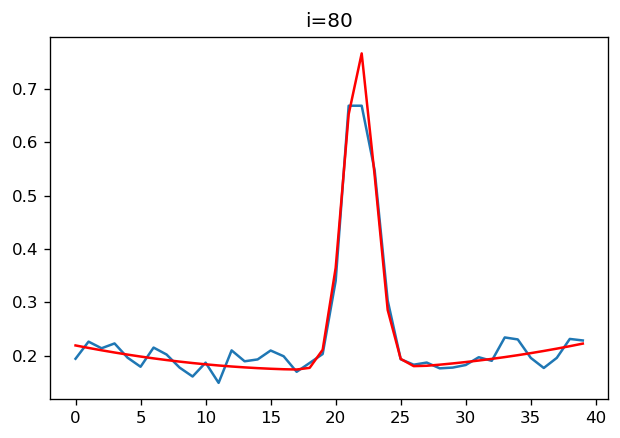

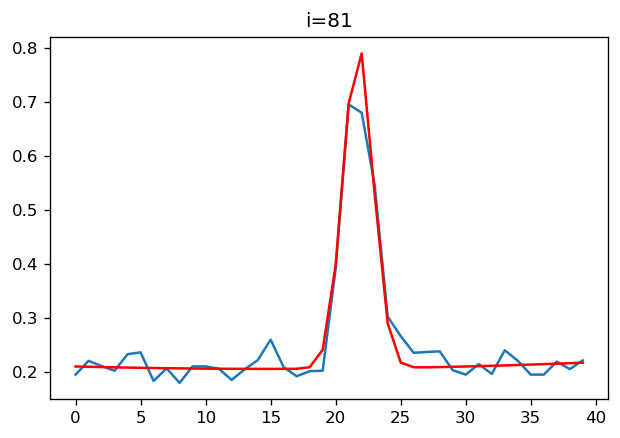

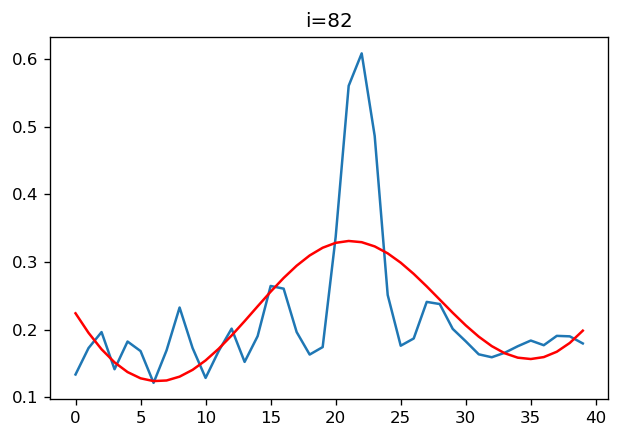

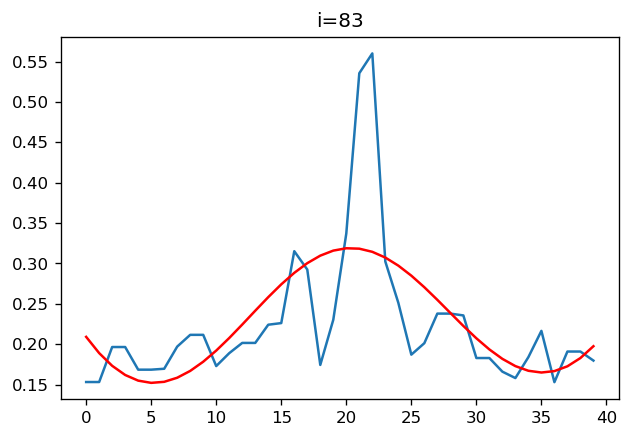

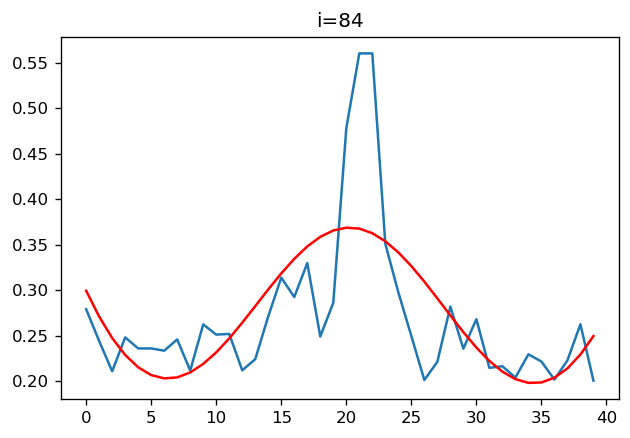

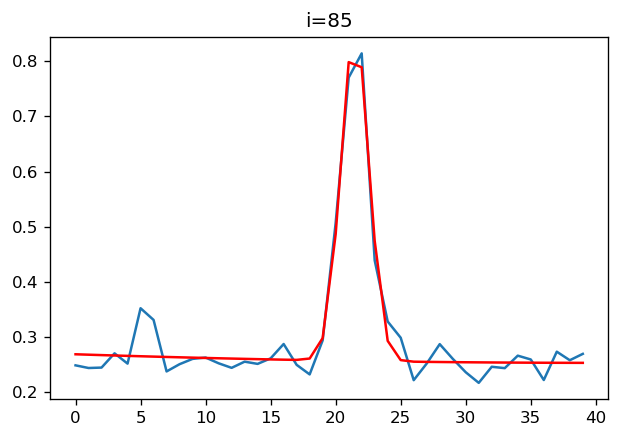

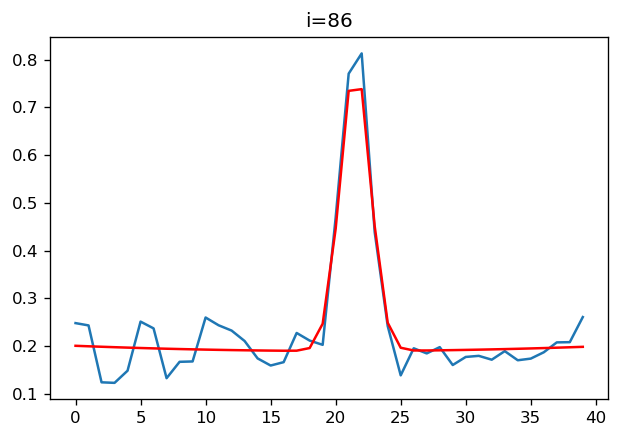

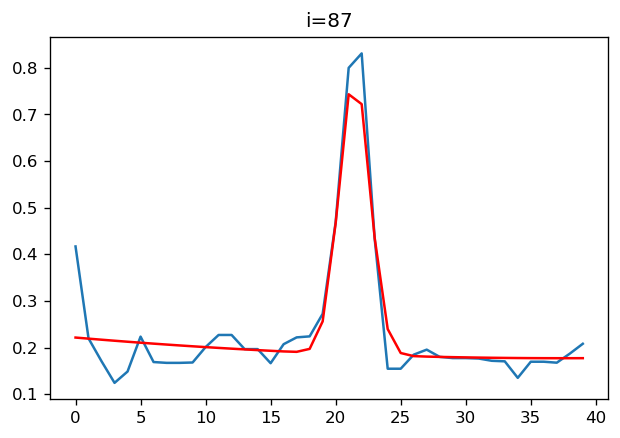

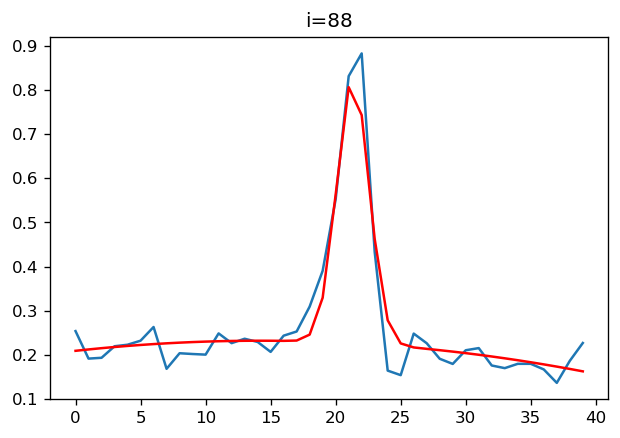

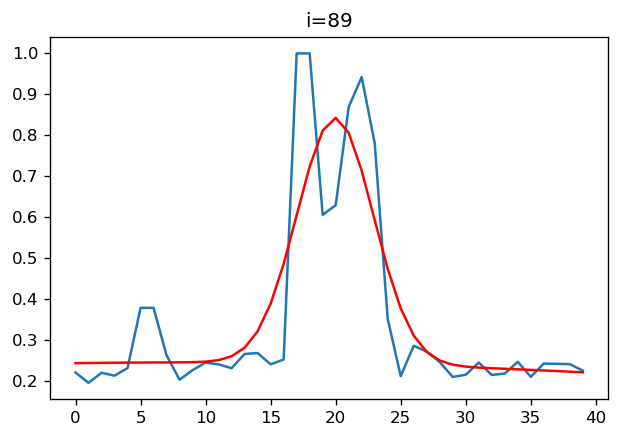

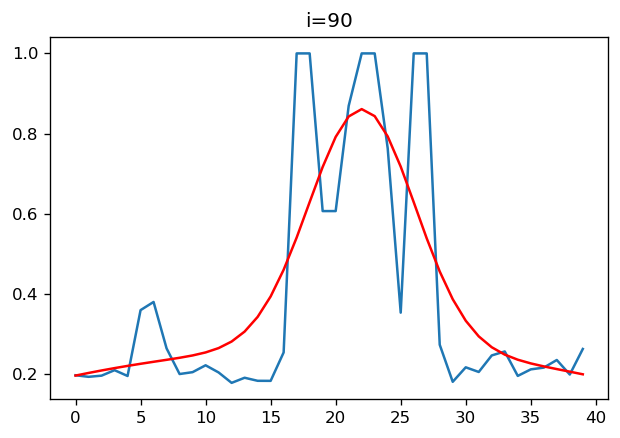

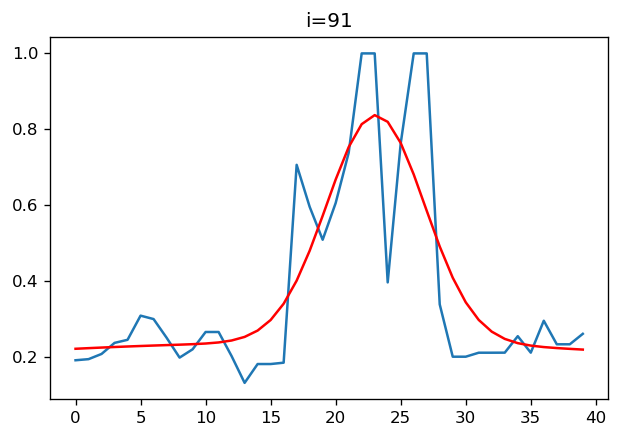

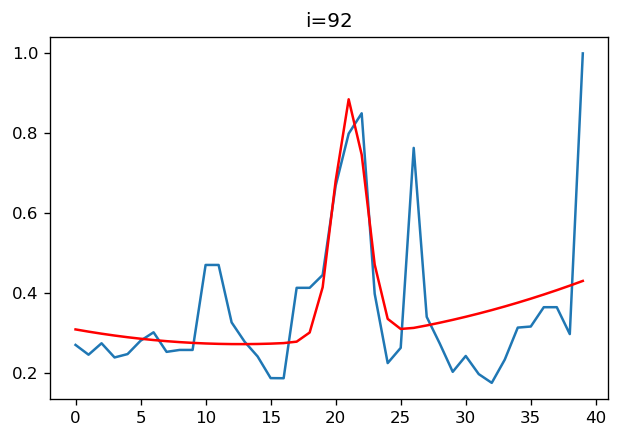

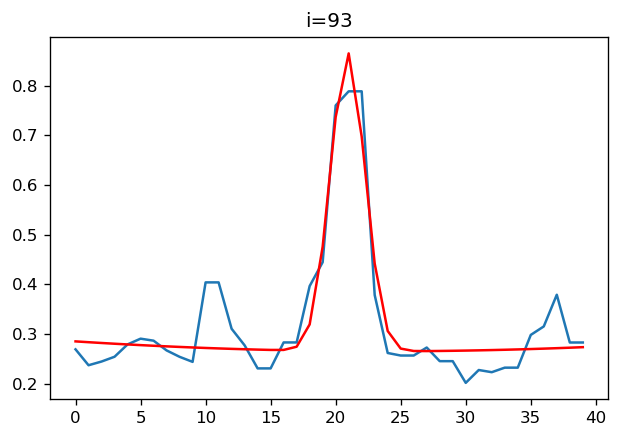

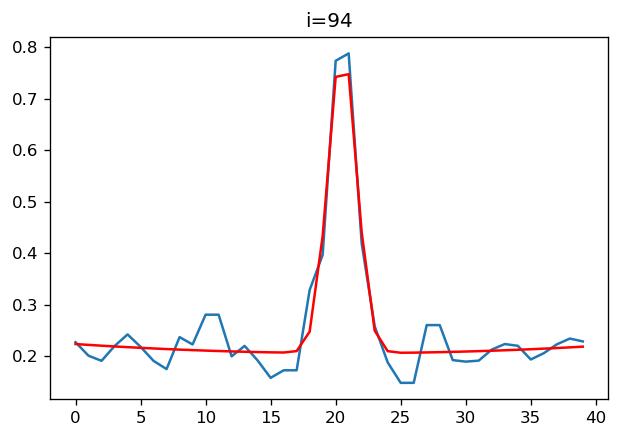

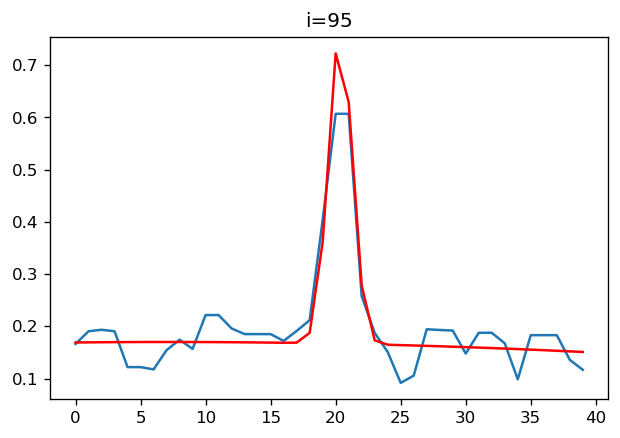

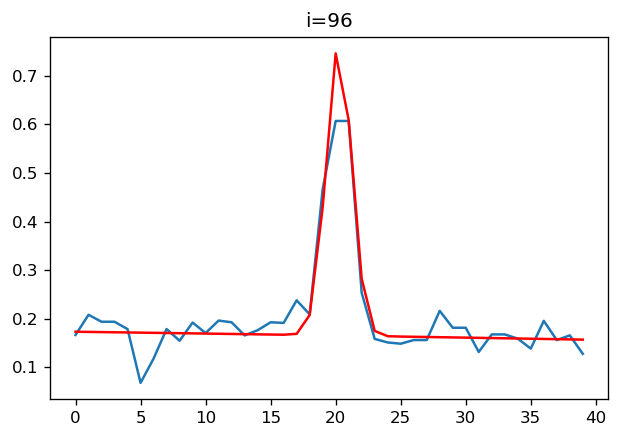

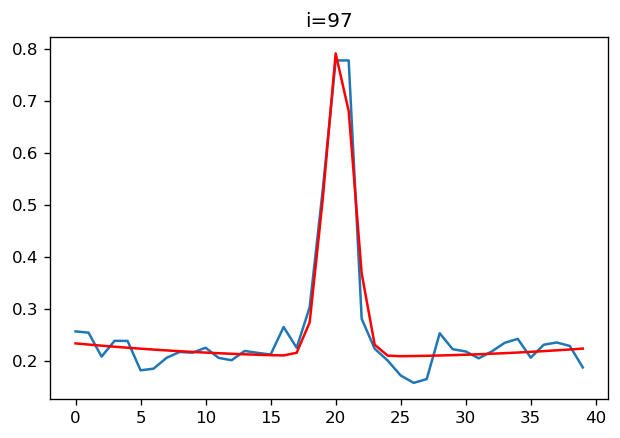

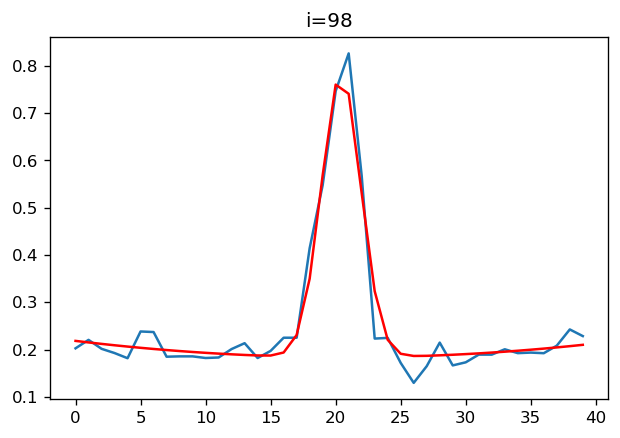

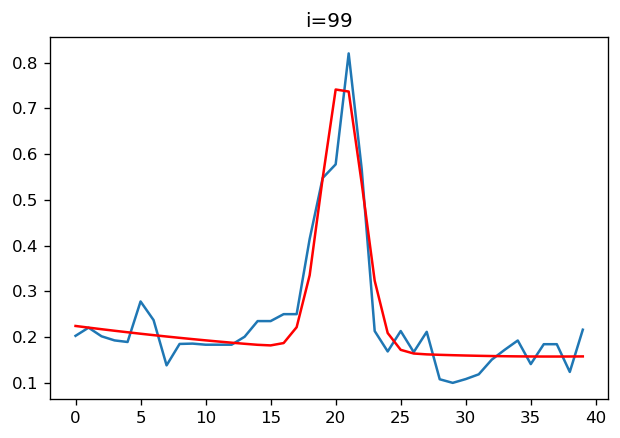

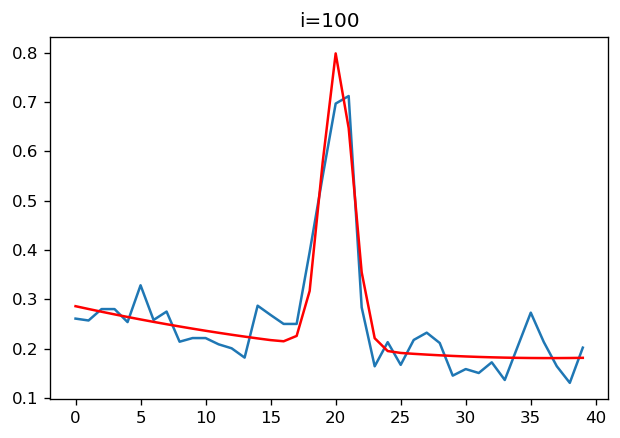

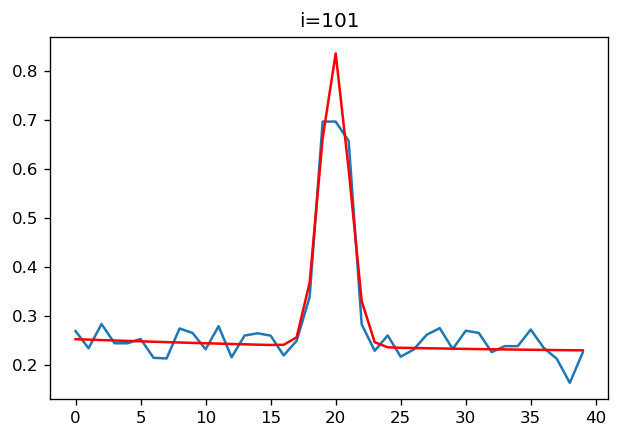

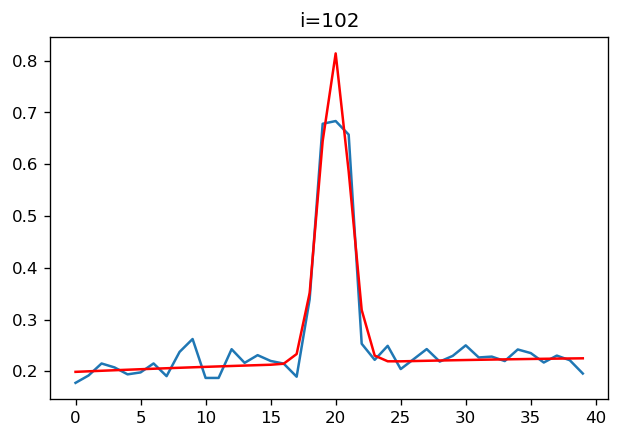

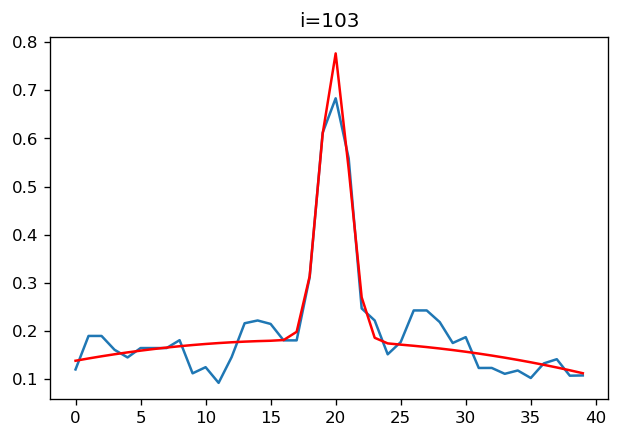

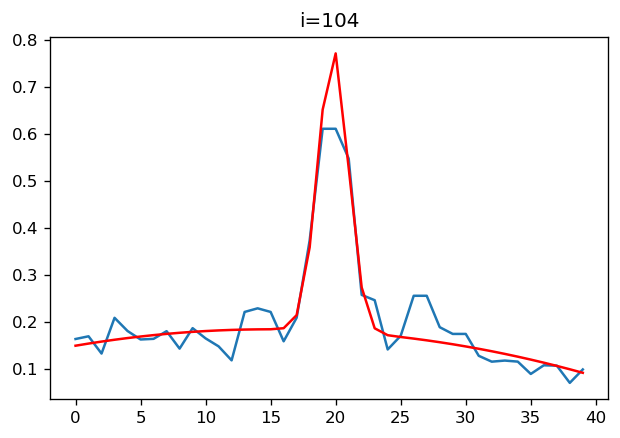

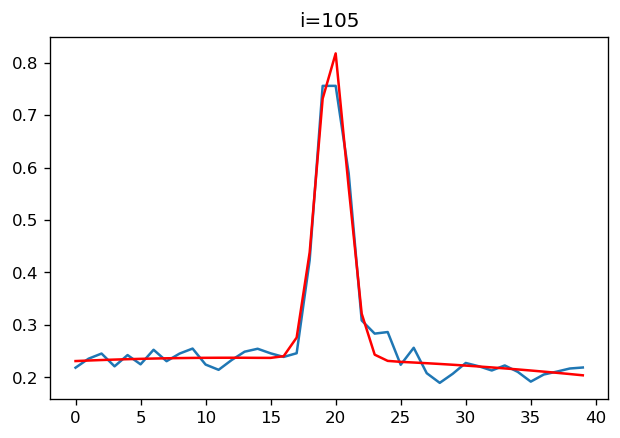

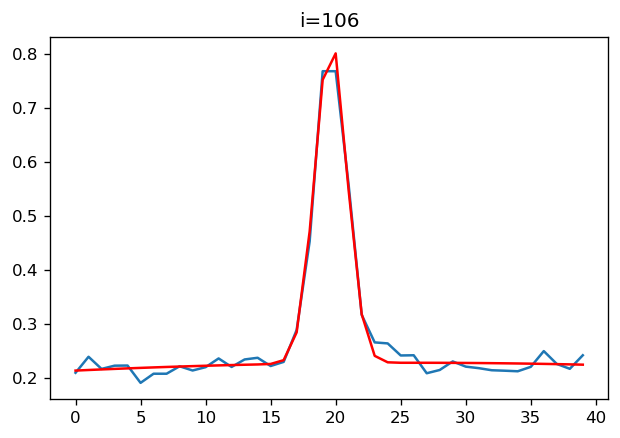

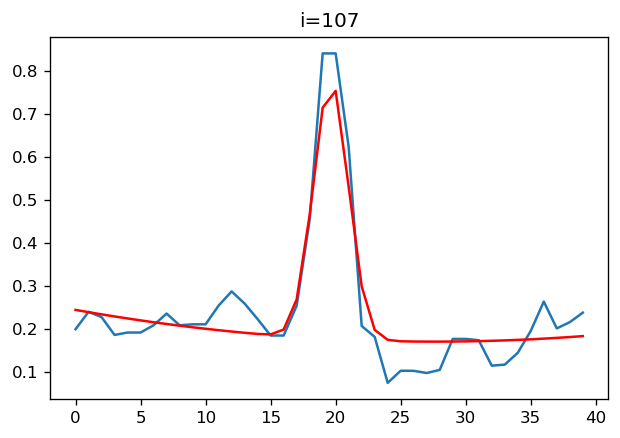

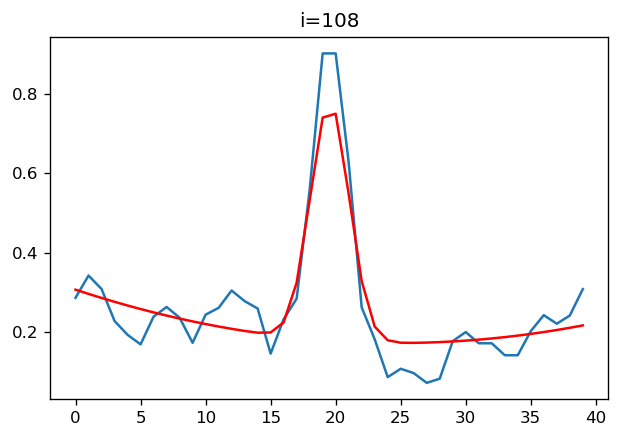

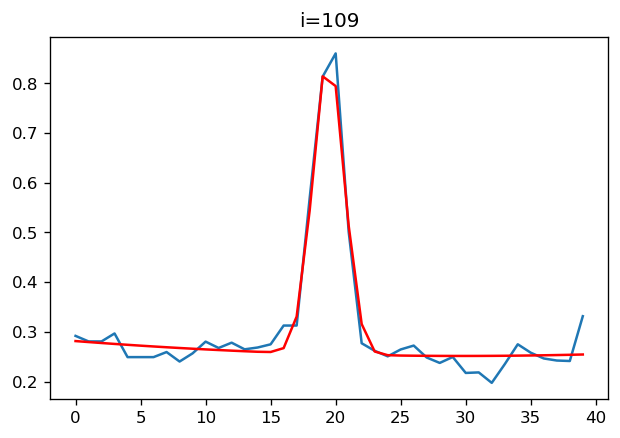

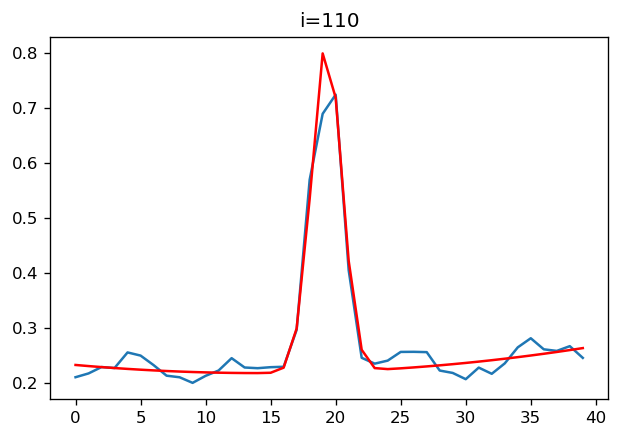

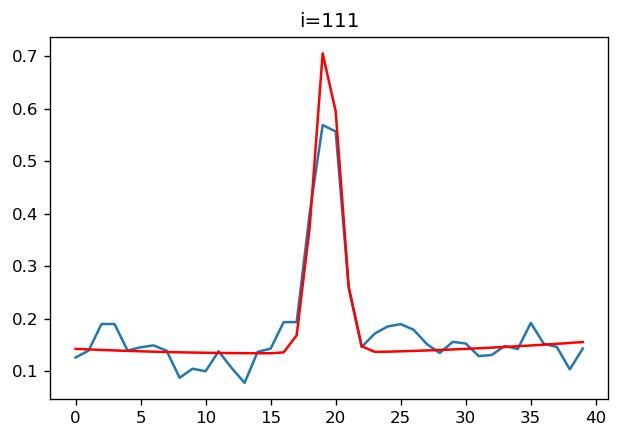

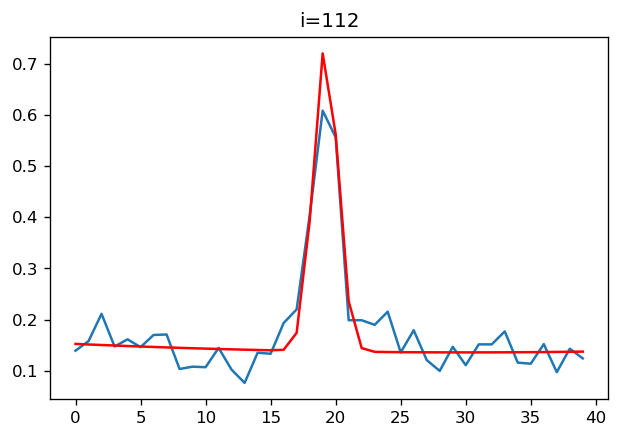

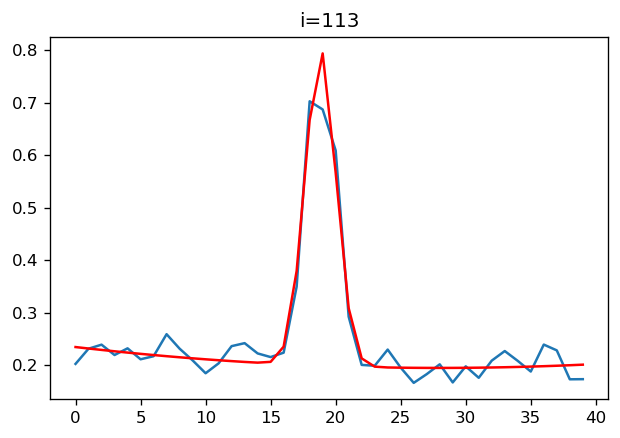

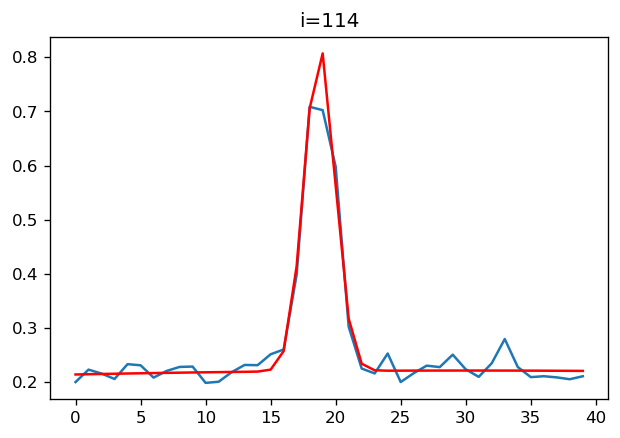

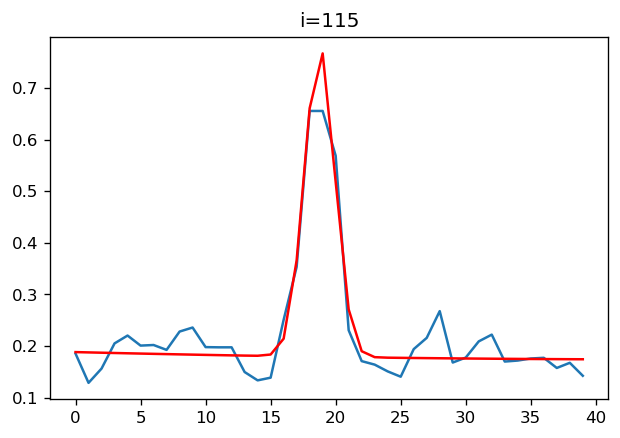

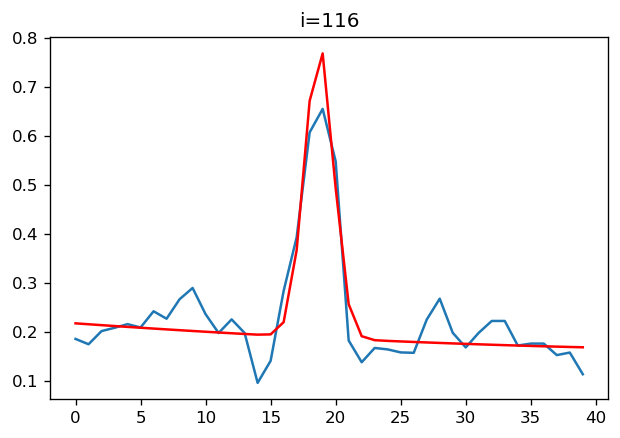

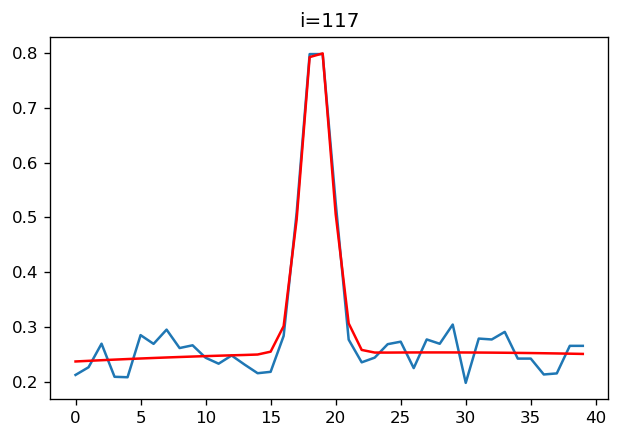

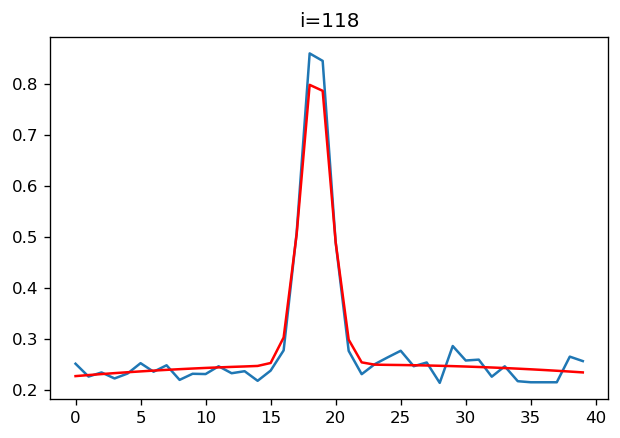

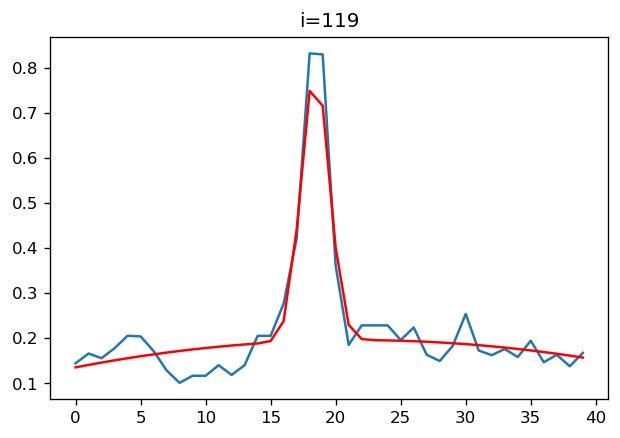

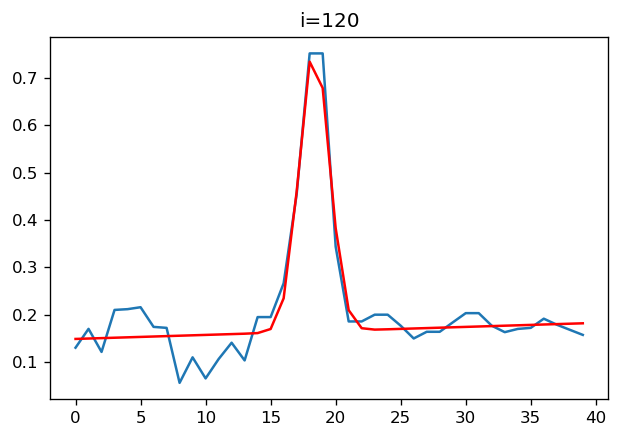

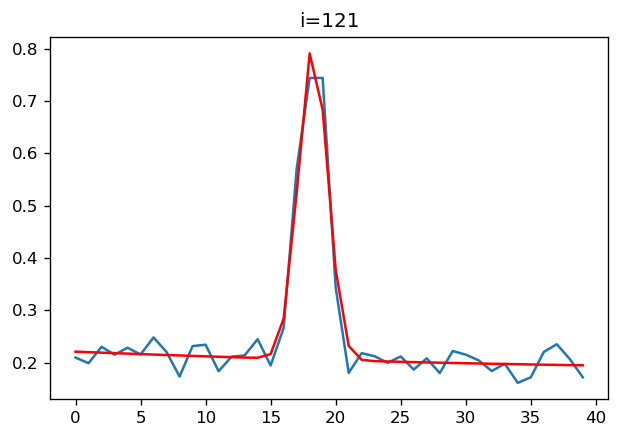

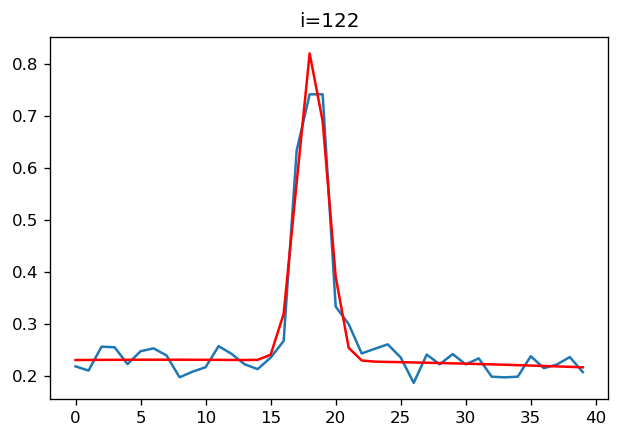

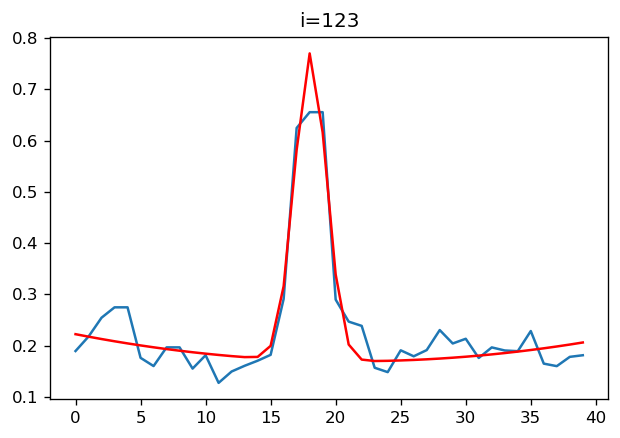

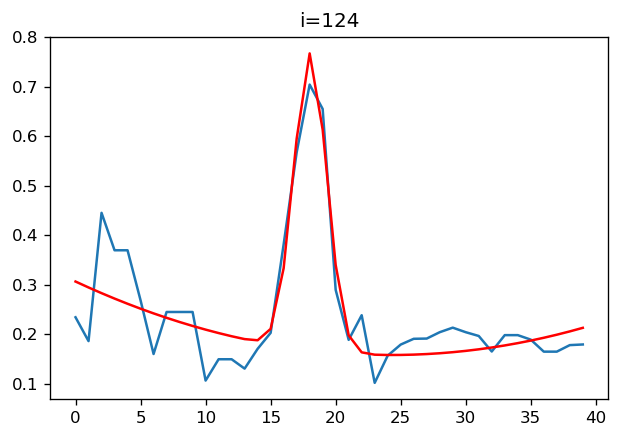

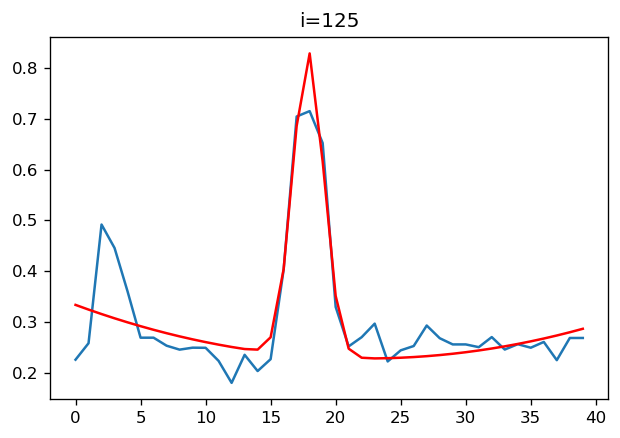

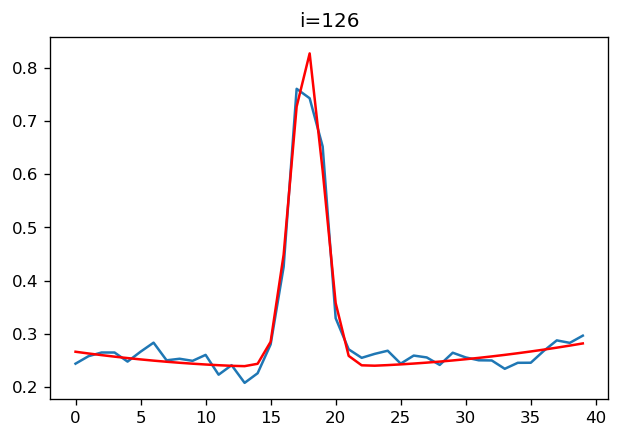

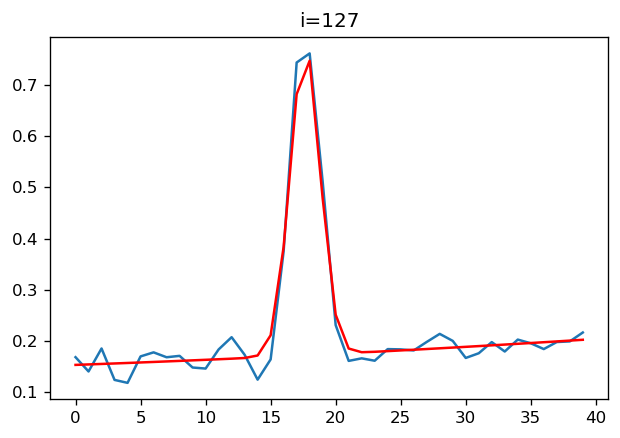

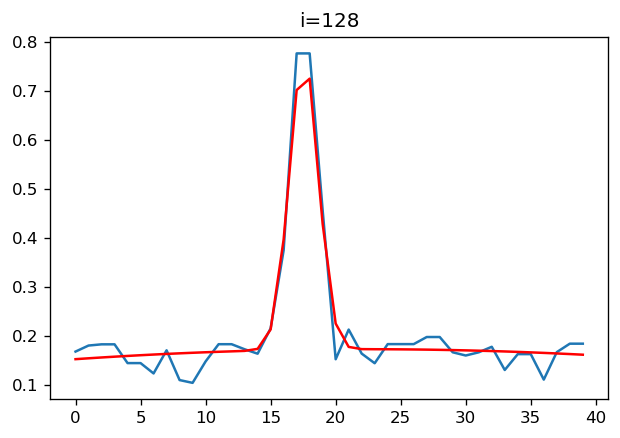

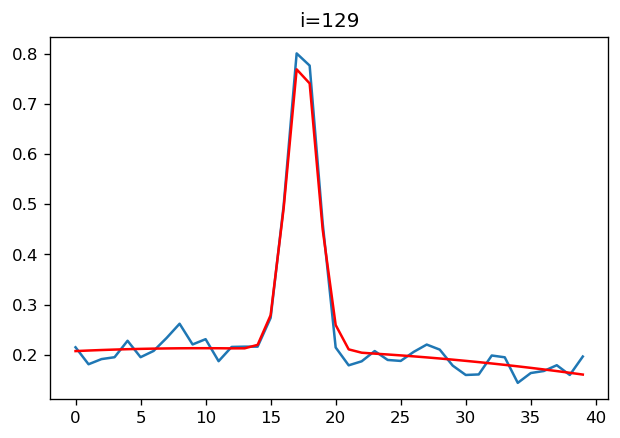

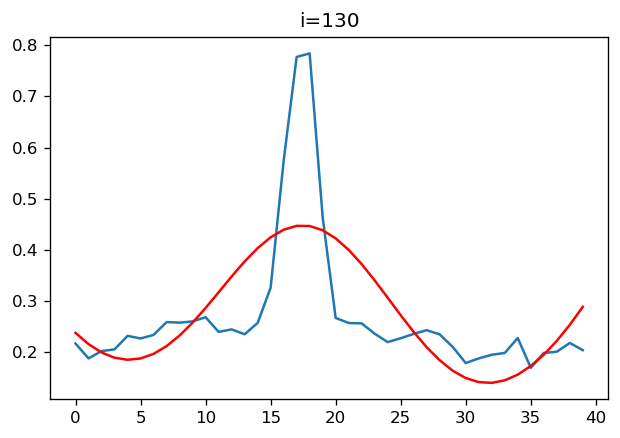

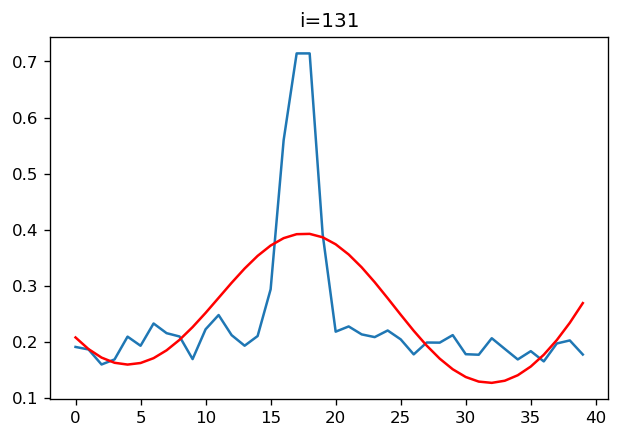

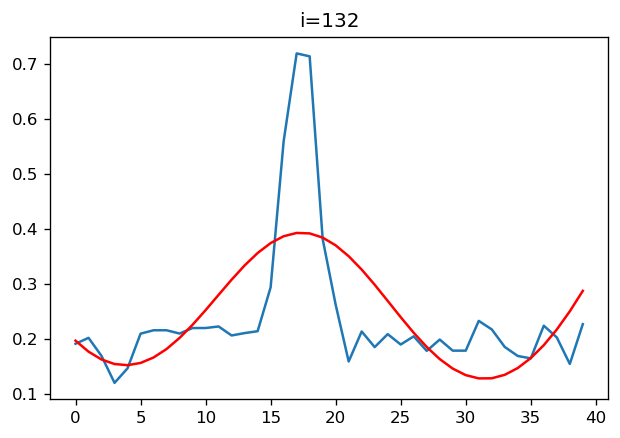

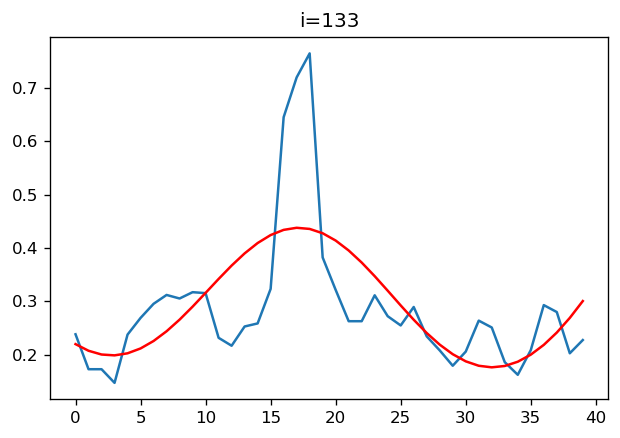

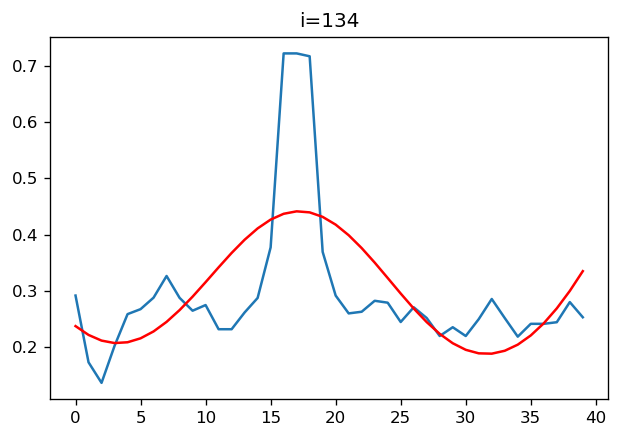

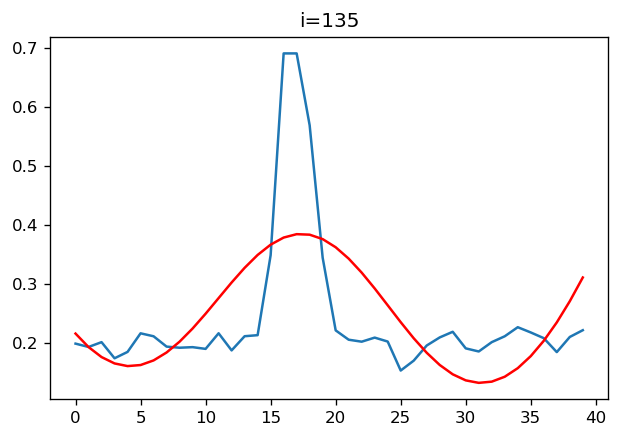

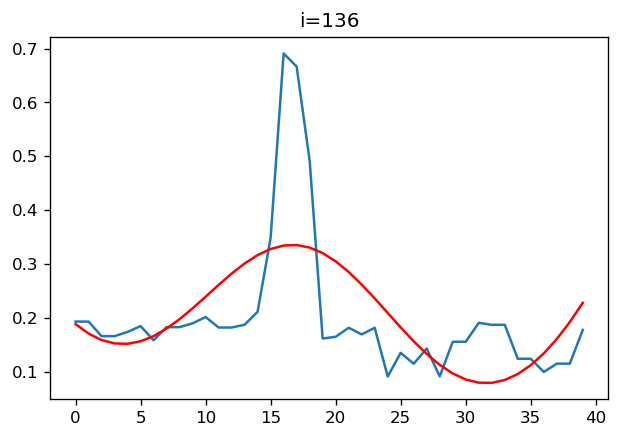

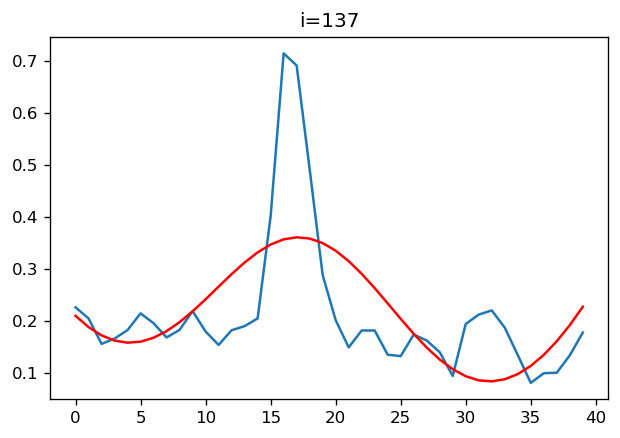

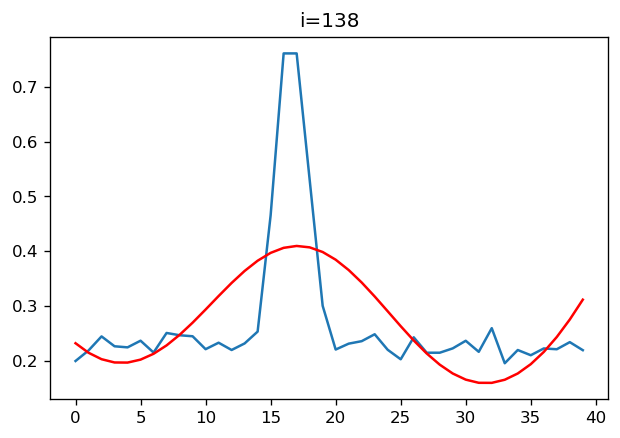

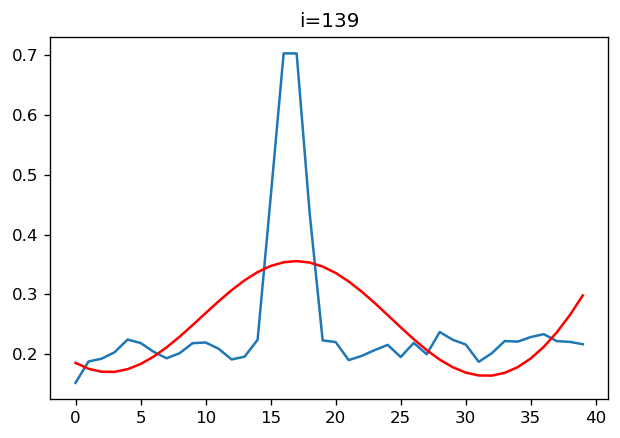

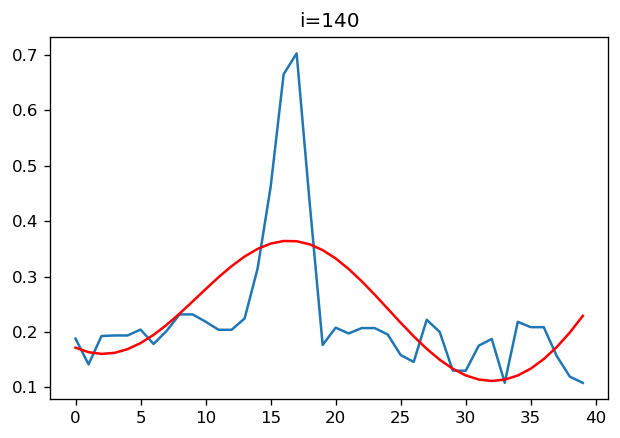

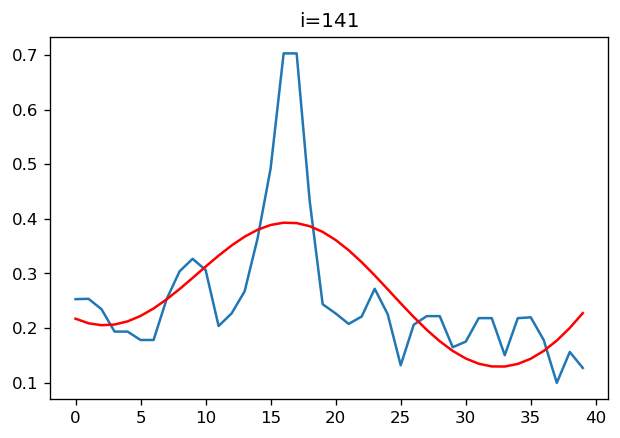

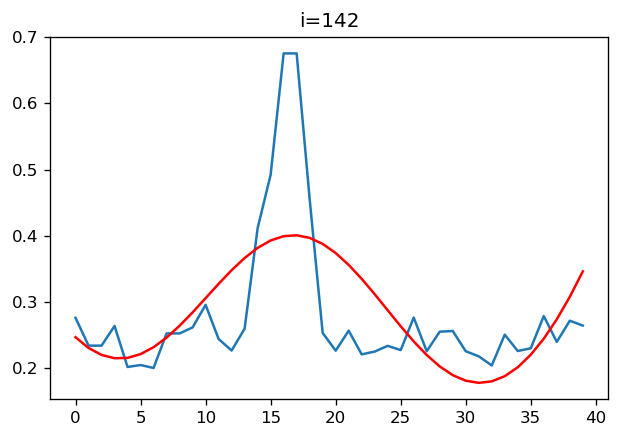

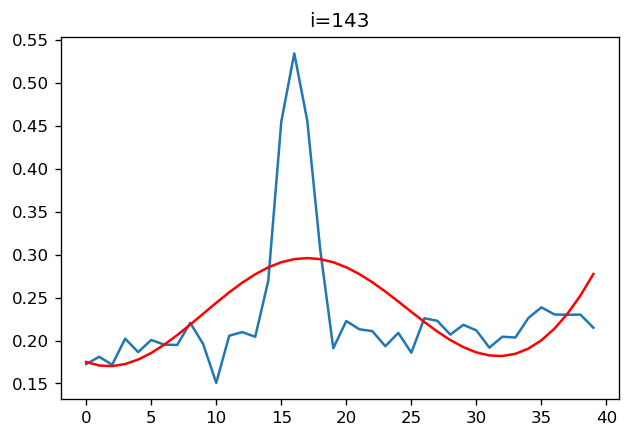

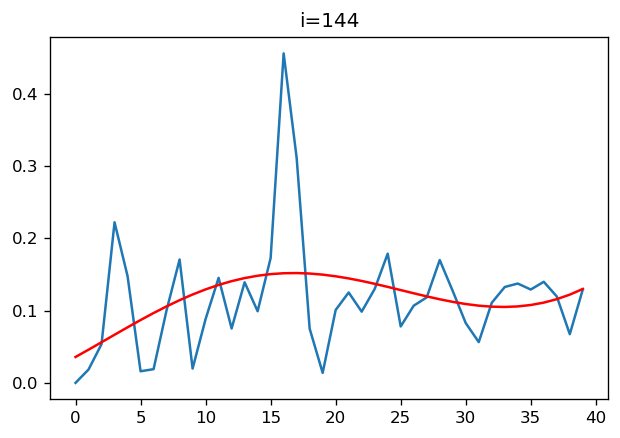

In [262]:
g = np.delete(skylines60p, np.s_[290:], 1)
h = np.delete(g, np.s_[:250], 1)
h = normalize(h)
waveaxis = np.linspace(0, np.size(h,1)-1, np.size(h,1))

upper_skyline = 145
lower_skyline = 20

sky2_a1 = np.zeros(upper_skyline - lower_skyline)

for i in range(lower_skyline, upper_skyline):           
    if i >= lower_skyline and i < 70:
        # create lmfit model with defined gaussian
        sky2_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky2_params = sky2_model.make_params()
        sky2_params.add('a0', value=0.6, min=0.3, max=0.9)
        sky2_params.add('a1', value=25)
        sky2_params.add('a2', value=3)
        sky2_params.add('a3', value=0.2)
        sky2_params.add('a4', value=0)
        sky2_params.add('a5', value=0)
    
        try:
            sky2_fit_result = sky2_model.fit(h[i], sky2_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky2_fit_result.fit_report())
        plt.figure()
        plt.title('i='+str(i))
        plt.plot(waveaxis, h[i])
        plt.plot(waveaxis, sky2_fit_result.best_fit, 'r-', label='best fit')
            
        sky2_a1[i-lower_skyline] = sky2_fit_result.params['a1'].value
        
    if i >= 70 and i < upper_skyline:
        # create lmfit model with defined gaussian
        sky2_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky2_params = sky2_model.make_params()
        sky2_params.add('a0', value=0.6, min=0.3, max=0.9)
        sky2_params.add('a1', value=20)
        sky2_params.add('a2', value=3)
        sky2_params.add('a3', value=0.2)
        sky2_params.add('a4', value=0)
        sky2_params.add('a5', value=0)
    
        try:
            sky2_fit_result = sky2_model.fit(h[i], sky2_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky2_fit_result.fit_report())
        plt.figure()
        plt.title('i='+str(i))
        plt.plot(waveaxis, h[i])
        plt.plot(waveaxis, sky2_fit_result.best_fit, 'r-', label='best fit')
            
        sky2_a1[i-lower_skyline] = sky2_fit_result.params['a1'].value
sky2_a1 = sky2_a1+250

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 125
    # variables        = 2
    chi-square         = 24.1164393
    reduced chi-square = 0.19606861
    Akaike info crit   = -201.677500
    Bayesian info crit = -196.020873
[[Variables]]
    slope:     -0.08832723 +/- 0.00109760 (1.24%) (init = -0.08832723)
    intercept:  278.976835 +/- 0.09833160 (0.04%) (init = 278.9768)
[[Correlations]] (unreported correlations are < 0.250)
    C(slope, intercept) = -0.915


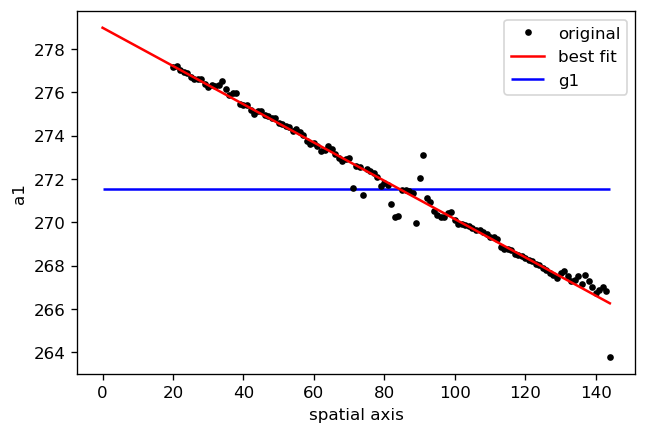

In [263]:
sky2_spat = np.linspace(0, len(sky2_a1)-1, len(sky2_a1))+20

x = sky2_spat
y = sky2_a1

mod = LinearModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

slope = out.params['slope'].value
intercept = out.params['intercept'].value

sky2_spat_all = np.linspace(0, np.size(skylines60p,0)-1, np.size(skylines60p,0))
sky2_a1_best_fit = slope*sky2_spat_all + intercept

plt.figure()
plt.plot(sky2_spat, sky2_a1,'k.', label = 'original')
plt.plot(sky2_spat_all, sky2_a1_best_fit, 'r', label = 'best fit')
plt.hlines((2.1873520195513567-y0)/m, xmin=sky2_spat_all[0], xmax=sky2_spat_all[-1], color='b', label = 'g1')
plt.xlabel('spatial axis')
plt.ylabel('a1')
plt.ticklabel_format(useOffset=False)
plt.legend()

In [266]:
sky2_pixel_offset_order35 = (2.1873520195513567-y0)/m - sky2_a1_best_fit
# np.savetxt('skylines60p_offset_order35.txt', sky2_pixel_offset_order35)
sky2_pixel_offset_order35

array([-7.44334268, -7.35501545, -7.26668823, -7.178361  , -7.09003377,
       -7.00170655, -6.91337932, -6.82505209, -6.73672486, -6.64839764,
       -6.56007041, -6.47174318, -6.38341596, -6.29508873, -6.2067615 ,
       -6.11843427, -6.03010705, -5.94177982, -5.85345259, -5.76512537,
       -5.67679814, -5.58847091, -5.50014368, -5.41181646, -5.32348923,
       -5.235162  , -5.14683478, -5.05850755, -4.97018032, -4.88185309,
       -4.79352587, -4.70519864, -4.61687141, -4.52854419, -4.44021696,
       -4.35188973, -4.26356251, -4.17523528, -4.08690805, -3.99858082,
       -3.9102536 , -3.82192637, -3.73359914, -3.64527192, -3.55694469,
       -3.46861746, -3.38029023, -3.29196301, -3.20363578, -3.11530855,
       -3.02698133, -2.9386541 , -2.85032687, -2.76199964, -2.67367242,
       -2.58534519, -2.49701796, -2.40869074, -2.32036351, -2.23203628,
       -2.14370905, -2.05538183, -1.9670546 , -1.87872737, -1.79040015,
       -1.70207292, -1.61374569, -1.52541846, -1.43709124, -1.34

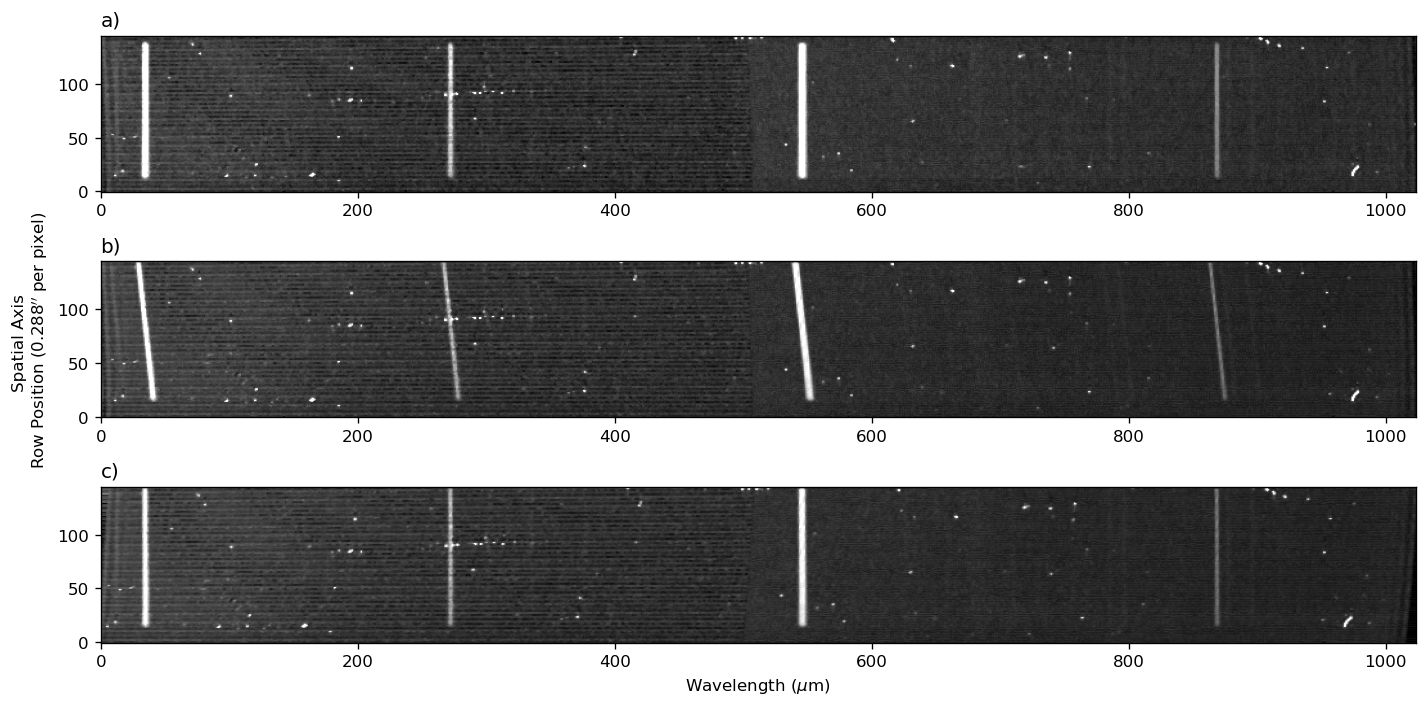

In [269]:
fig = plt.figure(figsize=(12,6), tight_layout=True)

fig.add_subplot(311)
plt.imshow(skylines60m, aspect='auto', cmap='gist_gray')
# plt.imshow(skylines60m, aspect='auto', extent=[waverange[0],waverange[-1],0,146], cmap='gist_gray')
plt.title('a)', loc='left')
# plt.xlabel('Wavelength ($\mu$m)')
# plt.ylabel('Spatial Axis \nRow Position (0.288$^{\prime\prime}$ per pixel)')
plt.gca().invert_yaxis()

fig.add_subplot(312)
plt.imshow(skylines60p, aspect='auto', cmap='gist_gray')
# plt.imshow(skylines60p, aspect='auto', extent=[waverange[0],waverange[-1],0,146], cmap='gist_gray')
# plt.xlabel('Wavelength ($\mu$m)')
plt.title('b)', loc='left')
plt.ylabel('Spatial Axis \nRow Position (0.288$^{\prime\prime}$ per pixel)')
plt.gca().invert_yaxis()

fig.add_subplot(313)
plt.imshow(skylines60p_shifted, aspect='auto', cmap='gist_gray')
# plt.imshow(skylines60p_shifted, aspect='auto', extent=[waverange[0],waverange[-1],0,146], cmap='gist_gray')
plt.title('c)', loc='left')
plt.xlabel('Wavelength ($\mu$m)')
plt.gca().invert_yaxis()

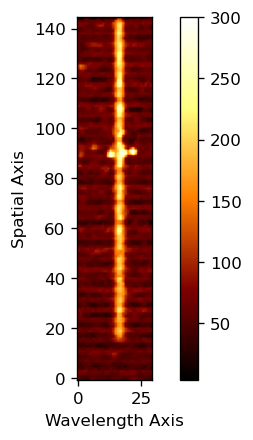

In [288]:
a = np.delete(skylines60p_shifted, np.s_[285:], 1)
b = np.delete(a, np.s_[:255], 1)

plt.figure()
plt.imshow(b, cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()
plt.colorbar()

Error occured at i=127


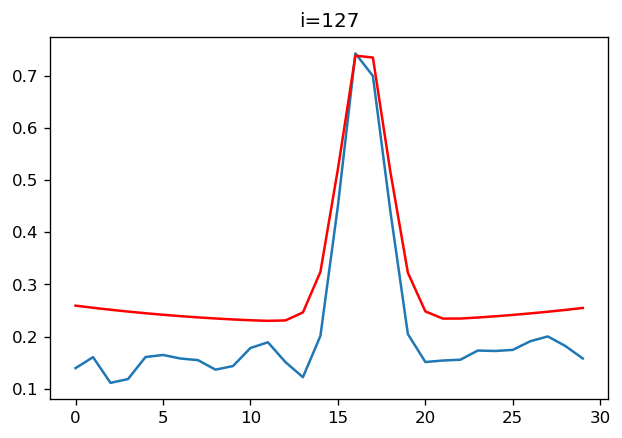

In [289]:
a = np.delete(skylines60p_shifted, np.s_[285:], 1)
b = np.delete(a, np.s_[:255], 1)
b = normalize(b)
waveaxis = np.linspace(0, np.size(b,1)-1, np.size(b,1))
# waveaxis = waverange[255:285]*100000

upper_skyline = 135
lower_skyline = 15

sky2_a1 = np.zeros(upper_skyline - lower_skyline)

for i in range(lower_skyline, upper_skyline):           
    if i >= lower_skyline and i < upper_skyline:
        # create lmfit model with defined gaussian
        sky2_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky2_params = sky2_model.make_params()
        sky2_params.add('a0', value=0.8, min=0.2, max=1)
        sky2_params.add('a1', value=17, min=12, max=22)
        sky2_params.add('a2', value=3)
        sky2_params.add('a3', value=0.3)
        sky2_params.add('a4', value=0)
        sky2_params.add('a5', value=0)
    
        try:
            sky2_fit_result = sky2_model.fit(b[i], sky2_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky2_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, b[i])
            plt.plot(waveaxis, sky2_fit_result.best_fit, 'r-', label='best fit')
            
        sky2_a1[i-lower_skyline] = sky2_fit_result.params['a1'].value
sky2_a1 = sky2_a1+255

[[Model]]
    Model(constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2
    # data points      = 120
    # variables        = 1
    chi-square         = 10.1892614
    reduced chi-square = 0.08562405
    Akaike info crit   = -293.938886
    Bayesian info crit = -291.151394
[[Variables]]
    c:  271.556114 +/- 0.02671205 (0.01%) (init = 271.5561)


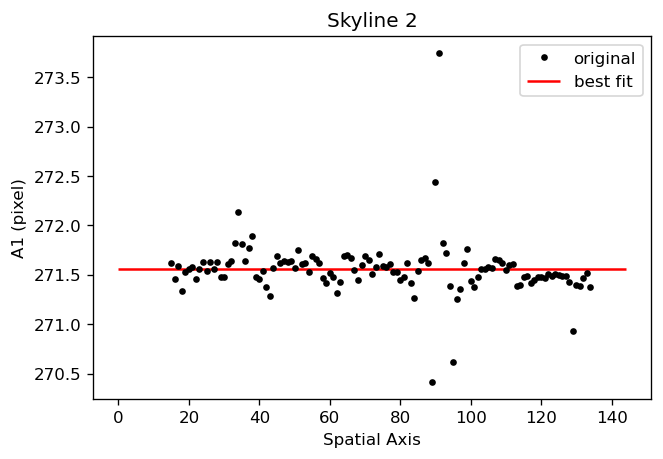

In [290]:
sky2_spat = np.linspace(0, len(sky2_a1)-1, len(sky2_a1))+15

x = sky2_spat
y = sky2_a1

mod = ConstantModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

sky2_spat_all = np.linspace(0, np.size(b,0)-1, np.size(b,0))
# sky2_slope = out.params['slope'].value
# sky2_intercept = out.params['intercept'].value
sky2_c = out.params['c'].value
sky2_a1_best_fit = sky2_c

plt.plot(x, y, '.k', label = 'original')
plt.hlines(sky2_a1_best_fit, xmin=sky2_spat_all[0], xmax=sky2_spat_all[-1], color='r', label='best fit')
# plt.hlines(g1_result.params['a1'].value, xmin=sky2_spat_all[0], xmax=sky2_spat_all[-1], color='b', label='g1')
plt.title('Skyline 2')
plt.xlabel('Spatial Axis')
plt.ylabel('A1 (pixel)')
plt.legend()

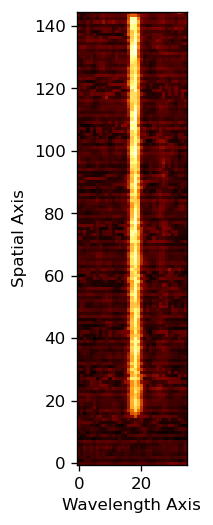

In [291]:
c = np.delete(skylines60p_shifted, np.s_[885:], 1)
d = np.delete(c, np.s_[:850], 1)

plt.figure(figsize=(2,5))
plt.imshow(d, cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()

Error occured at i=61
Error occured at i=80
Error occured at i=94
Error occured at i=95
Error occured at i=96
Error occured at i=97
Error occured at i=98
Error occured at i=100
Error occured at i=131
Error occured at i=132
Error occured at i=133


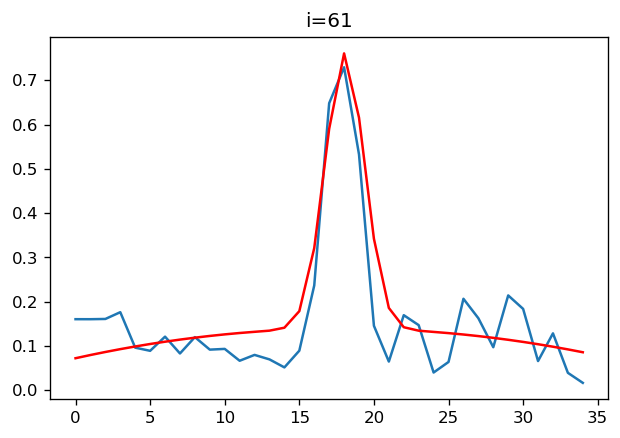

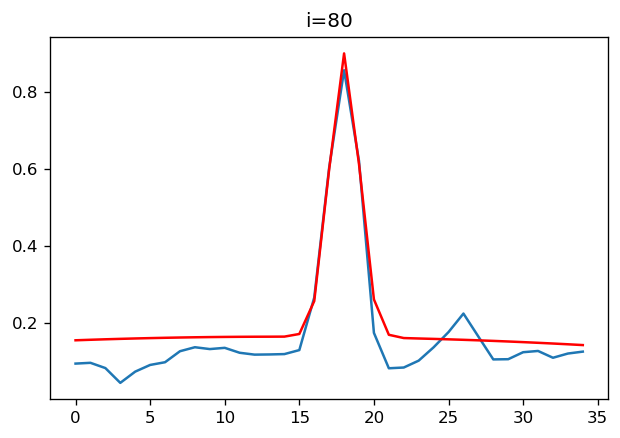

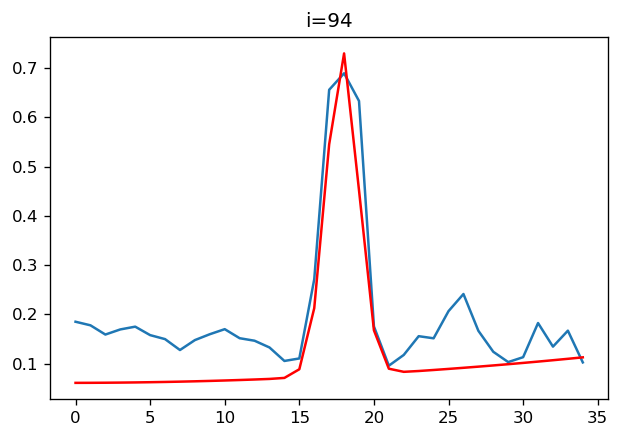

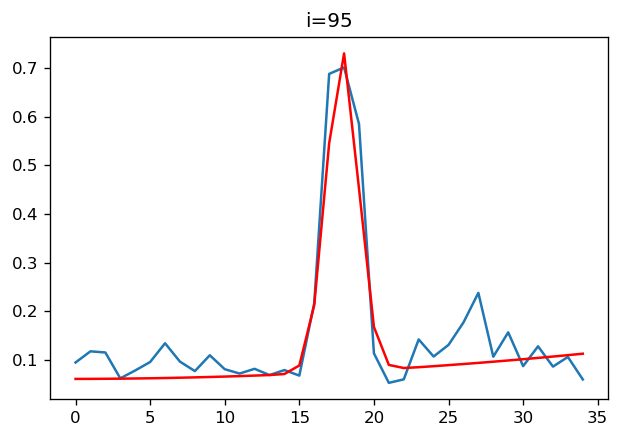

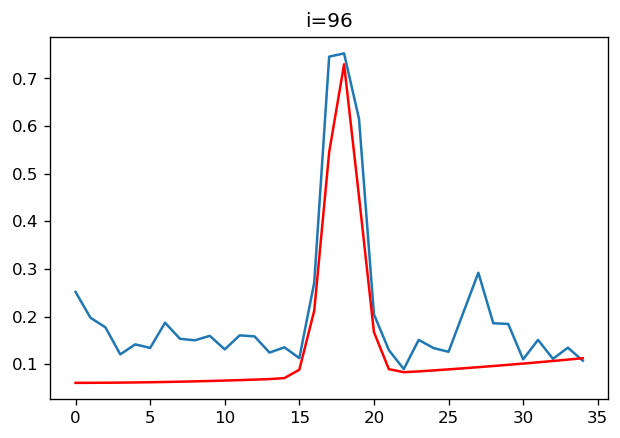

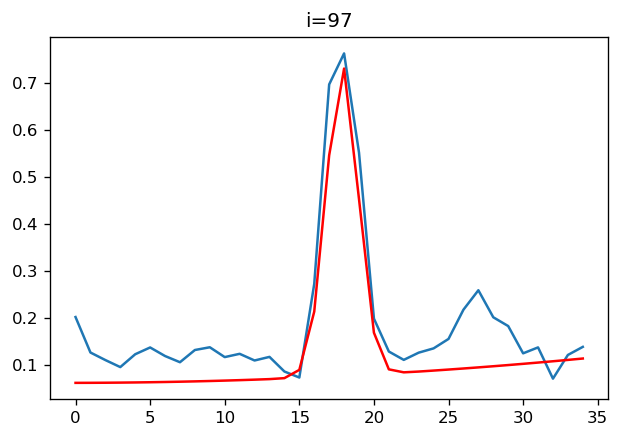

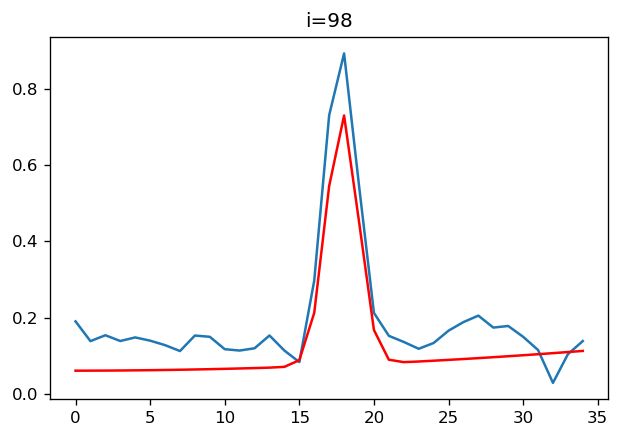

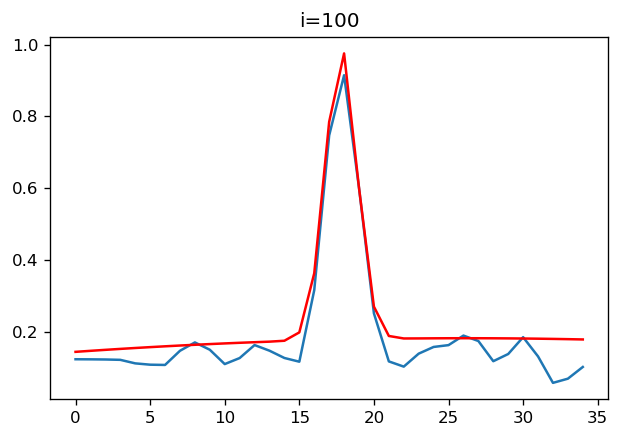

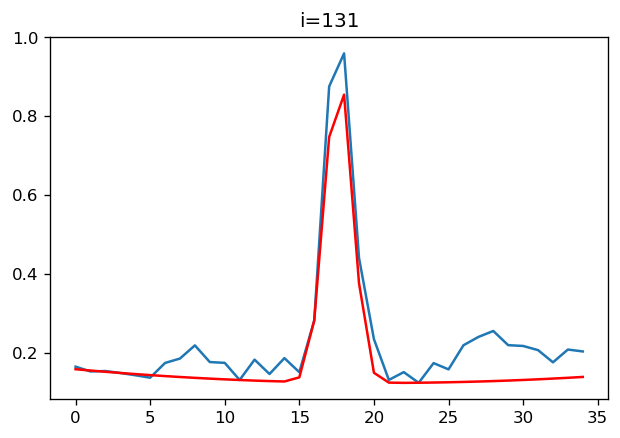

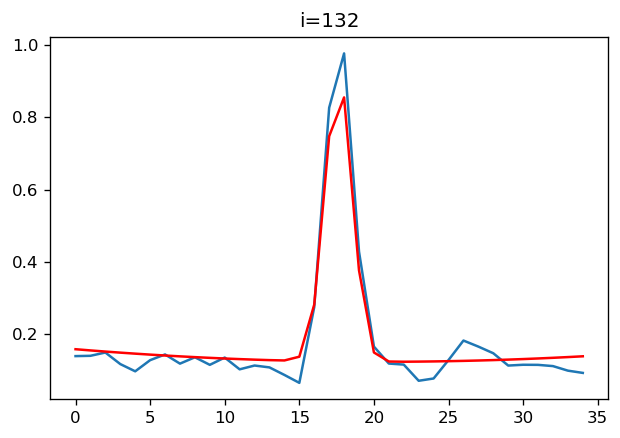

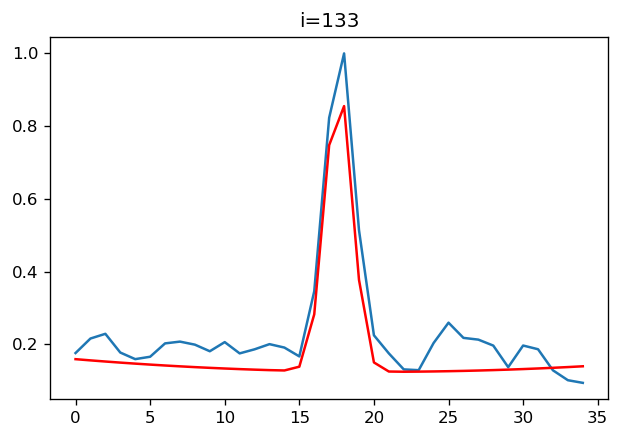

In [292]:
c = np.delete(skylines60p_shifted, np.s_[885:], 1)
d = np.delete(c, np.s_[:850], 1)
d = normalize(d)
waveaxis = np.linspace(0, np.size(d,1)-1, np.size(d,1))
# waveaxis = waverange[255:285]*100000

upper_skyline = 135
lower_skyline = 15

sky4_a1 = np.zeros(upper_skyline - lower_skyline)

for i in range(lower_skyline, upper_skyline):           
    if i >= lower_skyline and i < upper_skyline:
        # create lmfit model with defined gaussian
        sky4_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky4_params = sky4_model.make_params()
        sky4_params.add('a0', value=0.8, min=0.2, max=1)
        sky4_params.add('a1', value=17, min=12, max=22)
        sky4_params.add('a2', value=3)
        sky4_params.add('a3', value=0.2)
        sky4_params.add('a4', value=0)
        sky4_params.add('a5', value=0)
    
        try:
            sky4_fit_result = sky4_model.fit(d[i], sky4_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky4_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, d[i])
            plt.plot(waveaxis, sky4_fit_result.best_fit, 'r-', label='best fit')
            
        sky4_a1[i-lower_skyline] = sky4_fit_result.params['a1'].value
sky4_a1 = sky4_a1+850

[[Model]]
    Model(constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2
    # data points      = 120
    # variables        = 1
    chi-square         = 2.08597874
    reduced chi-square = 0.01752923
    Akaike info crit   = -484.270429
    Bayesian info crit = -481.482938
[[Variables]]
    c:  867.895464 +/- 0.01208623 (0.00%) (init = 867.8955)


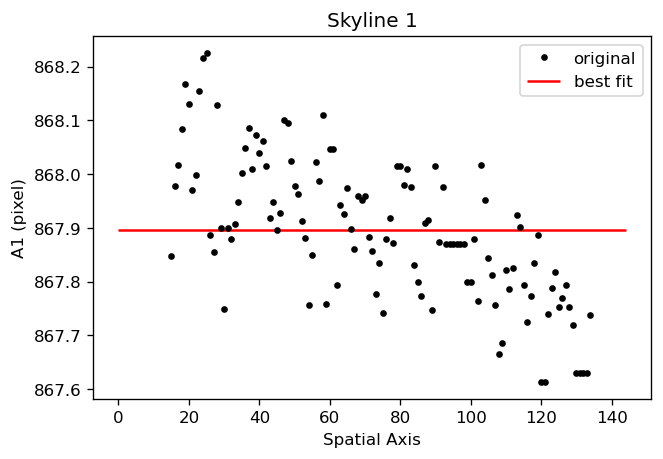

In [293]:
sky4_spat = np.linspace(0, len(sky4_a1)-1, len(sky4_a1))+15

x = sky4_spat
y = sky4_a1

mod = ConstantModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

sky4_spat_all = np.linspace(0, np.size(d,0)-1, np.size(d,0))
# sky4_slope = out.params['slope'].value
# sky4_intercept = out.params['intercept'].value
sky4_c = out.params['c'].value
sky4_a1_best_fit = sky4_c

plt.plot(x, y, '.k', label = 'original')
plt.hlines(sky4_a1_best_fit, xmin=sky4_spat_all[0], xmax=sky4_spat_all[-1], color='r', label='best fit')
# plt.hlines(g1_result.params['a1'].value, xmin=sky4_spat_all[0], xmax=sky4_spat_all[-1], color='b', label='g1')
plt.title('Skyline 1')
plt.xlabel('Spatial Axis')
plt.ylabel('A1 (pixel)')
plt.legend()

In [300]:
sky2_wave_best_fit = sky2_a1_best_fit*m + y0
sky4_wave_best_fit = sky4_a1_best_fit*m + y0
sky4_wave_best_fit

2.2052369160165624

In [302]:
print(sky2_wave_best_fit)
print(sky4_wave_best_fit)
print(sky2_a1_best_fit)
print(sky4_a1_best_fit)

R = (sky2_wave_best_fit + sky4_wave_best_fit)*0.5/((sky4_wave_best_fit - sky2_wave_best_fit)/(sky4_a1_best_fit - sky2_a1_best_fit))
R

2.1873526979853097
2.2052369160165624
271.556114324119
867.8954644502808


73234.23454151815